# Apperal Recommendation Exercise

In [77]:
# Importing necessary modules.

import numpy as np

import pandas as pd

import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib import gridspec

from sklearn.metrics import pairwise_distances

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity 

import math

In [78]:
# Additional module import for our utility functions.

import requests
from PIL import Image
from io import BytesIO
import re
from collections import Counter

In [3]:
# Load PreProcessed data stored in pickle file.

data = pd.read_pickle('pickels/16k_apperal_data_preprocessed')

In [4]:
# View first few rows of the data.

data.head()

asin                        brand              color  \
4   B004GSI2OS                  FeatherLite  Onyx Black/ Stone   
6   B012YX2ZPI  HX-Kingdom Fashion T-shirts              White   
15  B003BSRPB0                  FeatherLite              White   
27  B014ICEJ1Q                        FNC7C             Purple   
46  B01NACPBG2                 Fifth Degree              Black   

                                     medium_image_url product_type_name  \
4   https://images-na.ssl-images-amazon.com/images...             SHIRT   
6   https://images-na.ssl-images-amazon.com/images...             SHIRT   
15  https://images-na.ssl-images-amazon.com/images...             SHIRT   
27  https://images-na.ssl-images-amazon.com/images...             SHIRT   
46  https://images-na.ssl-images-amazon.com/images...             SHIRT   

                                                title formatted_price  
4   featherlite ladies long sleeve stain resistant...          $26.26  
6   womens unique 100 cotton  special olympics wor...           $9.99  
15  featherlite ladies moisture free mesh sport sh...          $20.54  
27  supernatural chibis sam dean castiel neck tshi...           $7.39  
46  fifth degree womens gold foil graphic tees jun...           $6.95

In [5]:
# Getting basic info of our data.
#    Our DataFrame has 16042 rows and 7 columns.

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16042 entries, 4 to 183120
Data columns (total 7 columns):
asin                 16042 non-null object
brand                15997 non-null object
color                16042 non-null object
medium_image_url     16042 non-null object
product_type_name    16042 non-null object
title                16042 non-null object
formatted_price      16042 non-null object
dtypes: object(7)
memory usage: 1002.6+ KB


#### Utility function to help us visualize our results.

In [79]:
#Display an image
def display_img(url,ax,fig):
    # we get the url of the apparel and download it
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    # we will display it in notebook 
    plt.imshow(img)
  
#plotting code to understand the algorithm's decision.
def plot_heatmap(keys, values, labels, url, text):
        # keys: list of words of recommended title
        # values: len(values) ==  len(keys), values(i) represents the occurence of the word keys(i)
        # labels: len(labels) == len(keys), the values of labels depends on the model we are using
                # if model == 'bag of words': labels(i) = values(i)
                # if model == 'tfidf weighted bag of words':labels(i) = tfidf(keys(i))
                # if model == 'idf weighted bag of words':labels(i) = idf(keys(i))
        # url : apparel's url

        # we will devide the whole figure into two parts
        gs = gridspec.GridSpec(2, 2, width_ratios=[4,1], height_ratios=[4,1]) 
        fig = plt.figure(figsize=(25,3))
        
        # 1st, ploting heat map that represents the count of commonly ocurred words in title2
        ax = plt.subplot(gs[0])
        # it displays a cell in white color if the word is intersection(lis of words of title1 and list of words of title2), in black if not
        ax = sns.heatmap(np.array([values]), annot=np.array([labels]))
        ax.set_xticklabels(keys) # set that axis labels as the words of title
        ax.set_title(text) # apparel title
        
        # 2nd, plotting image of the the apparel
        ax = plt.subplot(gs[1])
        # we don't want any grid lines for image and no labels on x-axis and y-axis
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        
        # we call dispaly_img based with paramete url
        display_img(url, ax, fig)
        
        # displays combine figure ( heat map and image together)
        plt.show()
    
def plot_heatmap_image(doc_id, vec1, vec2, url, text, model):

    # doc_id : index of the title1
    # vec1 : input apparels's vector, it is of a dict type {word:count}
    # vec2 : recommended apparels's vector, it is of a dict type {word:count}
    # url : apparels image url
    # text: title of recomonded apparel (used to keep title of image)
    # model, it can be any of the models, 
        # 1. bag_of_words
        # 2. tfidf
        # 3. idf

    # we find the common words in both titles, because these only words contribute to the distance between two title vec's
    intersection = set(vec1.keys()) & set(vec2.keys()) 

    # we set the values of non intersecting words to zero, this is just to show the difference in heatmap
    for i in vec2:
        if i not in intersection:
            vec2[i]=0

    # for labeling heatmap, keys contains list of all words in title2
    keys = list(vec2.keys())
    #  if ith word in intersection(lis of words of title1 and list of words of title2): values(i)=count of that word in title2 else values(i)=0 
    values = [vec2[x] for x in vec2.keys()]
    
    # labels: len(labels) == len(keys), the values of labels depends on the model we are using
        # if model == 'bag of words': labels(i) = values(i)
        # if model == 'tfidf weighted bag of words':labels(i) = tfidf(keys(i))
        # if model == 'idf weighted bag of words':labels(i) = idf(keys(i))

    if model == 'bag_of_words':
        labels = values
    elif model == 'tfidf':
        labels = []
        for x in vec2.keys():
            # tfidf_title_vectorizer.vocabulary_ it contains all the words in the corpus
            # tfidf_title_features[doc_id, index_of_word_in_corpus] will give the tfidf value of word in given document (doc_id)
            if x in  tfidf_title_vectorizer.vocabulary_:
                labels.append(tfidf_title_features[doc_id, tfidf_title_vectorizer.vocabulary_[x]])
            else:
                labels.append(0)
    elif model == 'idf':
        labels = []
        for x in vec2.keys():
            # idf_title_vectorizer.vocabulary_ it contains all the words in the corpus
            # idf_title_features[doc_id, index_of_word_in_corpus] will give the idf value of word in given document (doc_id)
            if x in  idf_title_vectorizer.vocabulary_:
                labels.append(idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[x]])
            else:
                labels.append(0)

    plot_heatmap(keys, values, labels, url, text)


# this function gets a list of wrods along with the frequency of each 
# word given "text"
def text_to_vector(text):
    word = re.compile(r'\w+')
    words = word.findall(text)
    # words stores list of all words in given string, you can try 'words = text.split()' this will also gives same result
    return Counter(words) # Counter counts the occurence of each word in list, it returns dict type object {word1:count}



def get_result(doc_id, content_a, content_b, url, model):
    text1 = content_a
    text2 = content_b
    
    # vector1 = dict{word11:#count, word12:#count, etc.}
    vector1 = text_to_vector(text1)

    # vector1 = dict{word21:#count, word22:#count, etc.}
    vector2 = text_to_vector(text2)

    plot_heatmap_image(doc_id, vector1, vector2, url, text2, model)

## Model: Bag of Words

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

title_features   = CountVectorizer().fit_transform(data['title'])
title_features.get_shape()

# CountVectorizer().fit_transform(corpus) returns 
# the a sparase matrix of dimensions #data_points * #words_in_corpus


(16042, 12609)

In [8]:
def bag_of_words_model(doc_id, num_results):
    # doc_id: apparel's id in given corpus
    # pairwise_dist will store the distance from given input apparel to all remaining apparels

    pairwise_dist = pairwise_distances(title_features,title_features[doc_id])
    
    # np.argsort will return indices of the smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]

    #pdists will store the smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])
    
    for i in range(0,len(indices)):
        # we will pass 1. doc_id, 2. title1, 3. title2, url, model
        get_result(indices[i],data['title'].loc[df_indices[0]], data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], 'bag_of_words')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print ('Brand:', data['brand'].loc[df_indices[i]])
        print ('Title:', data['title'].loc[df_indices[i]])
        print ('Euclidean similarity with the query image :', pdists[i])
        print('='*60)


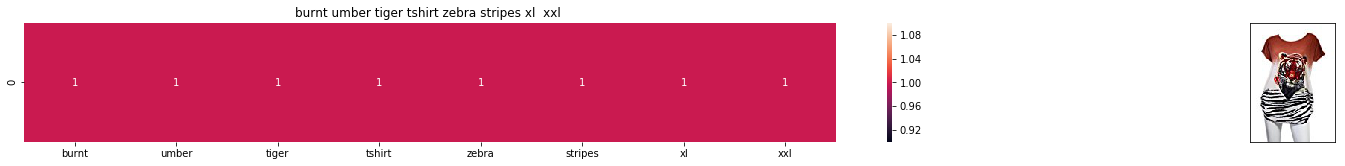

ASIN : B00JXQB5FQ
Brand: Si Row
Title: burnt umber tiger tshirt zebra stripes xl  xxl 
Euclidean similarity with the query image : 0.0


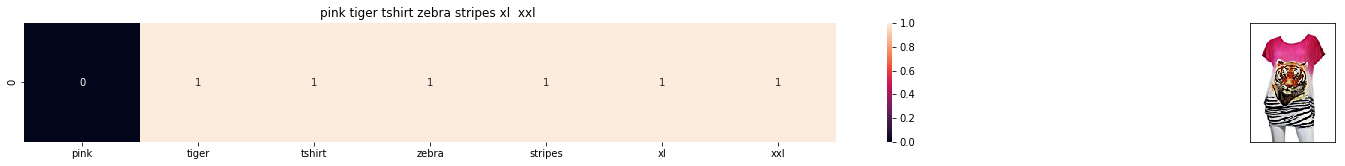

ASIN : B00JXQASS6
Brand: Si Row
Title: pink tiger tshirt zebra stripes xl  xxl 
Euclidean similarity with the query image : 1.7320508075688772


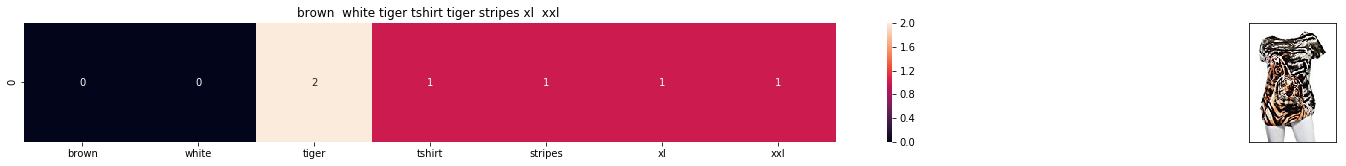

ASIN : B00JXQCWTO
Brand: Si Row
Title: brown  white tiger tshirt tiger stripes xl  xxl 
Euclidean similarity with the query image : 2.449489742783178


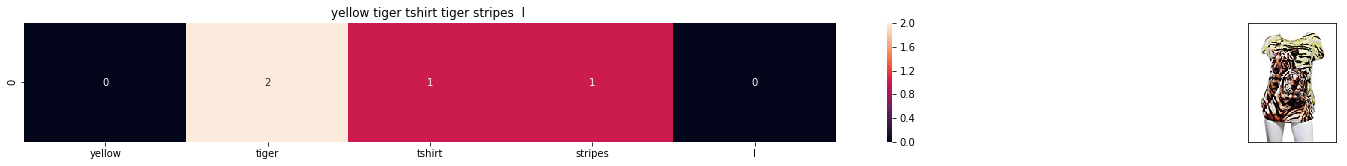

ASIN : B00JXQCUIC
Brand: Si Row
Title: yellow tiger tshirt tiger stripes  l 
Euclidean similarity with the query image : 2.6457513110645907


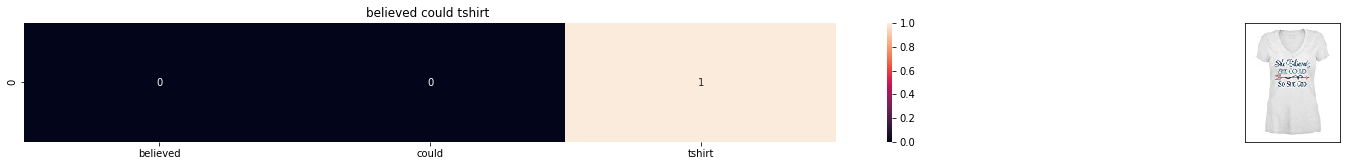

ASIN : B07568NZX4
Brand: Rustic Grace
Title: believed could tshirt 
Euclidean similarity with the query image : 3.0


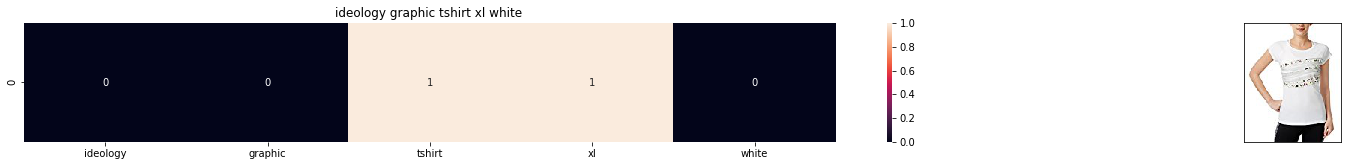

ASIN : B01NB0NKRO
Brand: Ideology
Title: ideology graphic tshirt xl white 
Euclidean similarity with the query image : 3.0


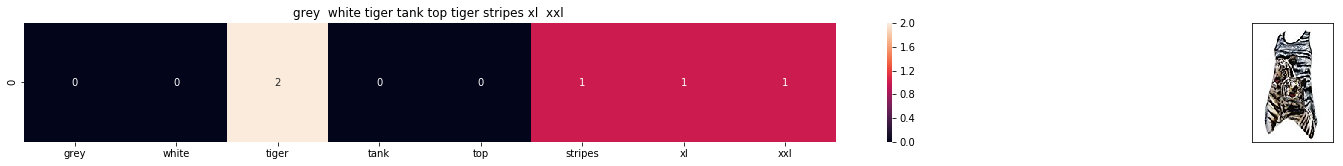

ASIN : B00JXQAFZ2
Brand: Si Row
Title: grey  white tiger tank top tiger stripes xl  xxl 
Euclidean similarity with the query image : 3.0


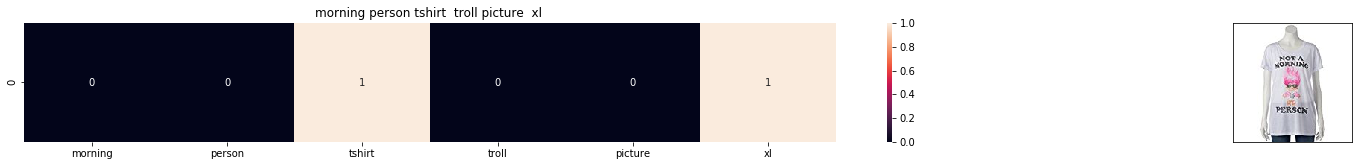

ASIN : B01CLS8LMW
Brand: Awake
Title: morning person tshirt  troll picture  xl 
Euclidean similarity with the query image : 3.1622776601683795


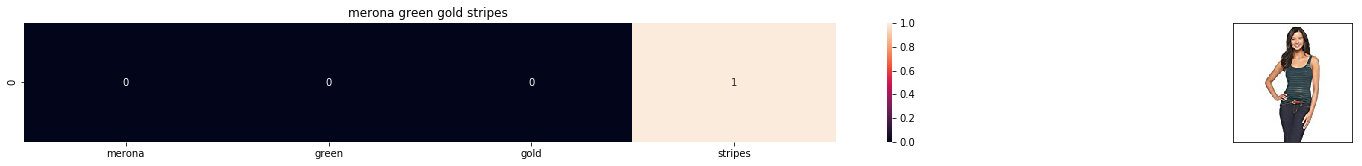

ASIN : B01KVZUB6G
Brand: Merona
Title: merona green gold stripes 
Euclidean similarity with the query image : 3.1622776601683795


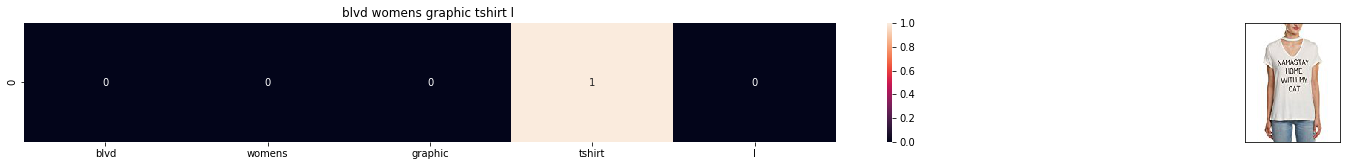

ASIN : B0733R2CJK
Brand: BLVD
Title: blvd womens graphic tshirt l 
Euclidean similarity with the query image : 3.1622776601683795


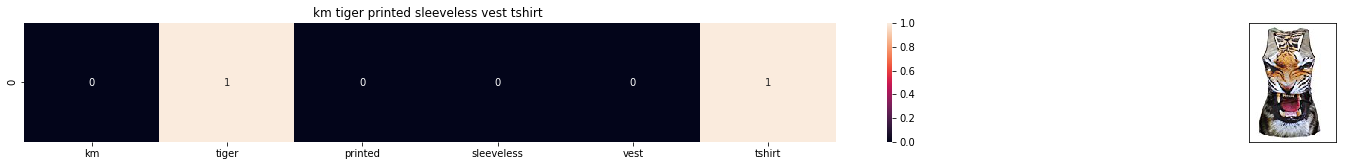

ASIN : B012VQLT6Y
Brand: KM T-shirt
Title: km tiger printed sleeveless vest tshirt 
Euclidean similarity with the query image : 3.1622776601683795


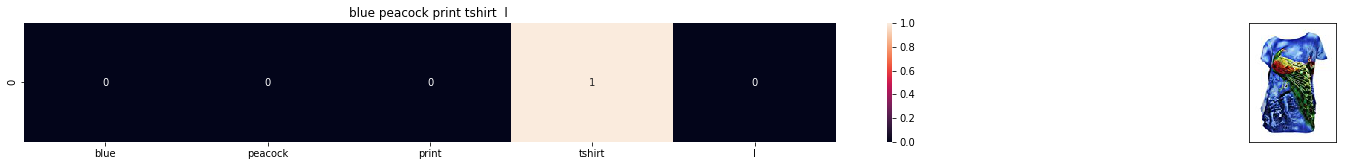

ASIN : B00JXQC8L6
Brand: Si Row
Title: blue peacock print tshirt  l 
Euclidean similarity with the query image : 3.1622776601683795


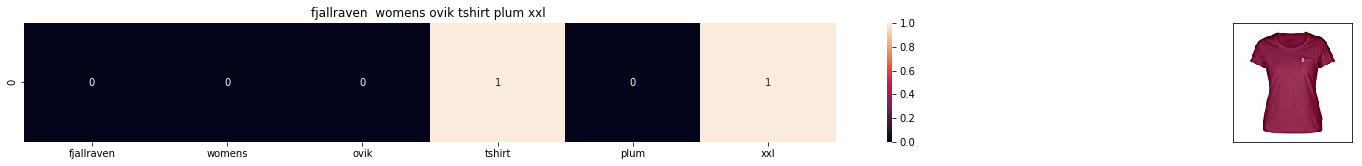

ASIN : B06XC3CZF6
Brand: Fjallraven
Title: fjallraven  womens ovik tshirt plum xxl 
Euclidean similarity with the query image : 3.1622776601683795


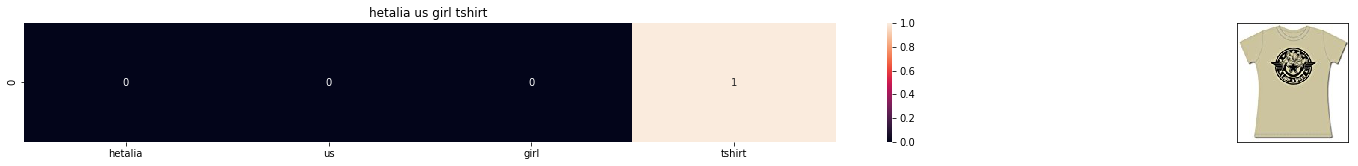

ASIN : B005IT8OBA
Brand: Hetalia
Title: hetalia us girl tshirt 
Euclidean similarity with the query image : 3.1622776601683795


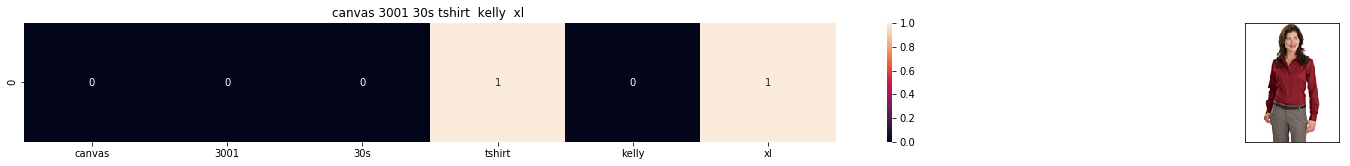

ASIN : B0088PN0LA
Brand: Red House
Title: canvas 3001 30s tshirt  kelly  xl 
Euclidean similarity with the query image : 3.1622776601683795


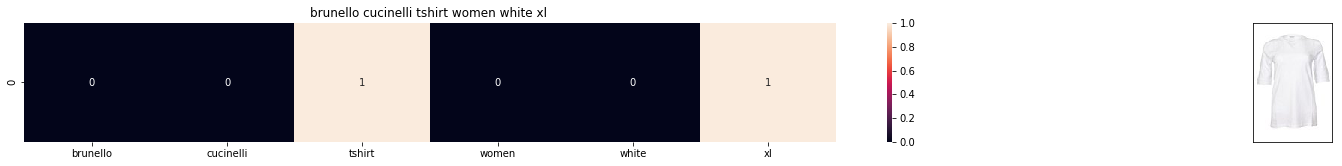

ASIN : B06X99V6WC
Brand: Brunello Cucinelli
Title: brunello cucinelli tshirt women white xl 
Euclidean similarity with the query image : 3.1622776601683795


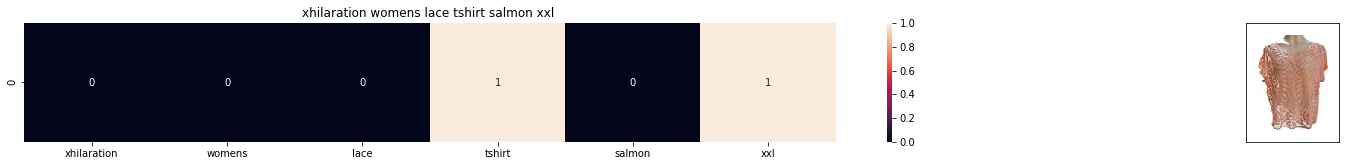

ASIN : B06Y1JPW1Q
Brand: Xhilaration
Title: xhilaration womens lace tshirt salmon xxl 
Euclidean similarity with the query image : 3.1622776601683795


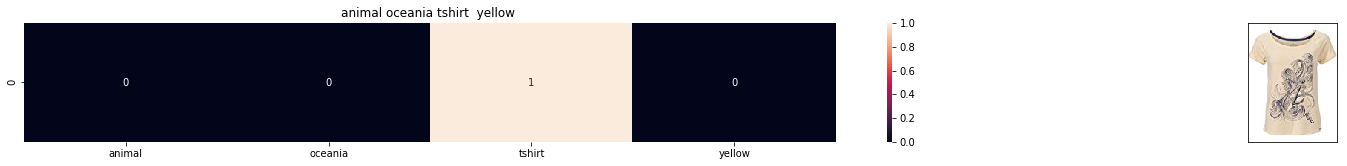

ASIN : B06X6GX6WG
Brand: Animal
Title: animal oceania tshirt  yellow 
Euclidean similarity with the query image : 3.1622776601683795


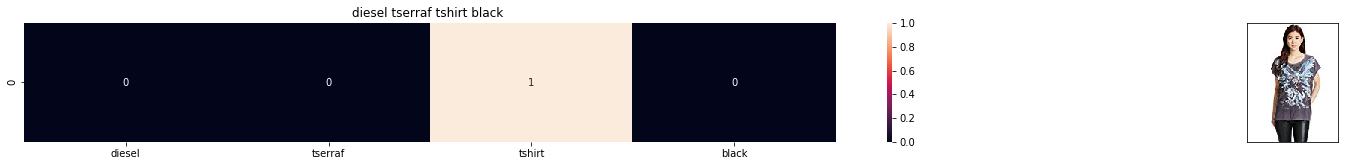

ASIN : B017X8PW9U
Brand: Diesel
Title: diesel tserraf tshirt black 
Euclidean similarity with the query image : 3.1622776601683795


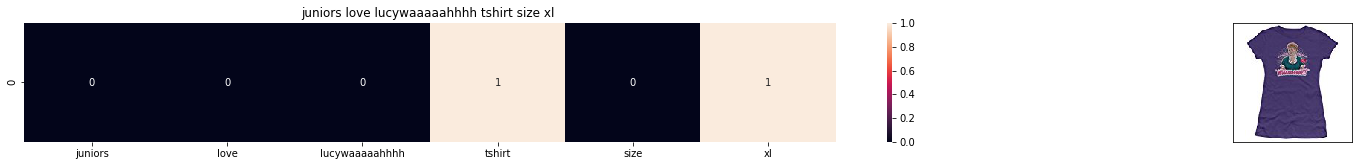

ASIN : B00IAA4JIQ
Brand: I Love Lucy
Title: juniors love lucywaaaaahhhh tshirt size xl 
Euclidean similarity with the query image : 3.1622776601683795


In [16]:
#call the bag-of-words model for a product to get similar products.
bag_of_words_model(12566, 20) # change the index if you want to.

# In the output heat map each value represents the count value 
# of the label word, the color represents the intersection 
# with inputs title.

#try 12566
#try 931

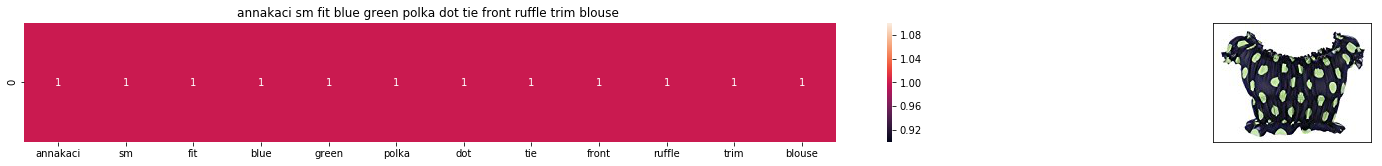

ASIN : B00KLHUIBS
Brand: Anna-Kaci
Title: annakaci sm fit blue green polka dot tie front ruffle trim blouse 
Euclidean similarity with the query image : 0.0


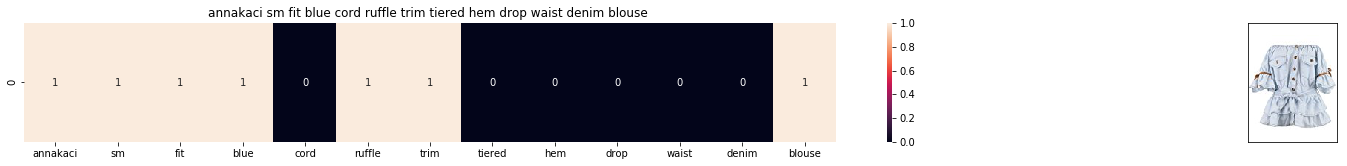

ASIN : B0759G15ZX
Brand: Anna-Kaci
Title: annakaci sm fit blue cord ruffle trim tiered hem drop waist denim blouse 
Euclidean similarity with the query image : 3.3166247903554


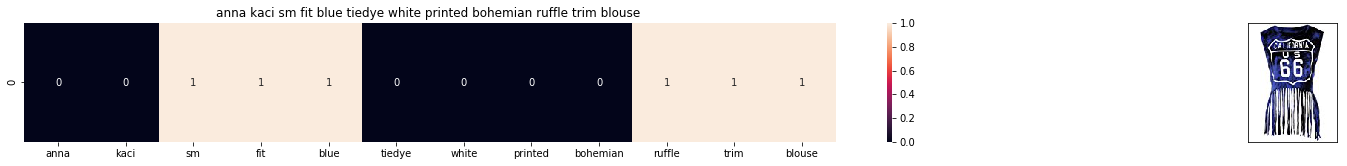

ASIN : B00YQ8S4K0
Brand: Anna-Kaci
Title: anna kaci sm fit blue tiedye white printed bohemian ruffle trim blouse 
Euclidean similarity with the query image : 3.4641016151377544


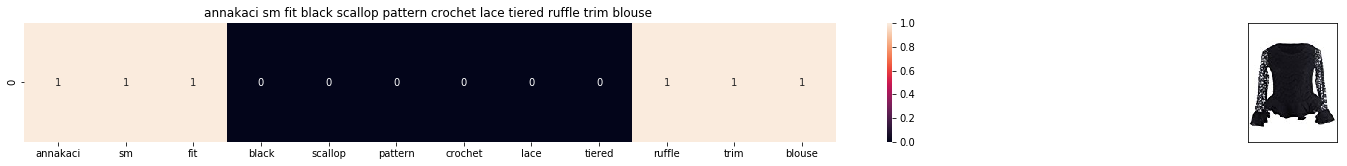

ASIN : B00O194W8W
Brand: Anna-Kaci
Title: annakaci sm fit black scallop pattern crochet lace tiered ruffle trim blouse 
Euclidean similarity with the query image : 3.4641016151377544


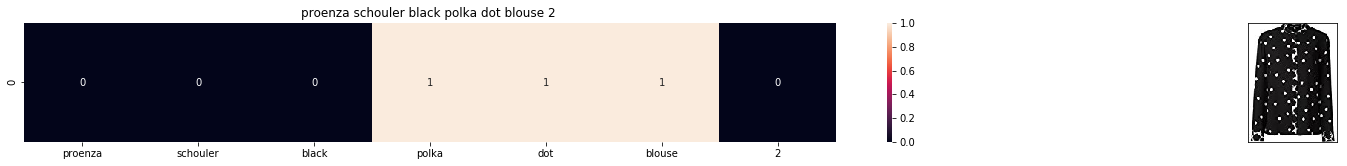

ASIN : B074TLHLMN
Brand: Proenza Schouler
Title: proenza schouler black polka dot blouse 2 
Euclidean similarity with the query image : 3.4641016151377544


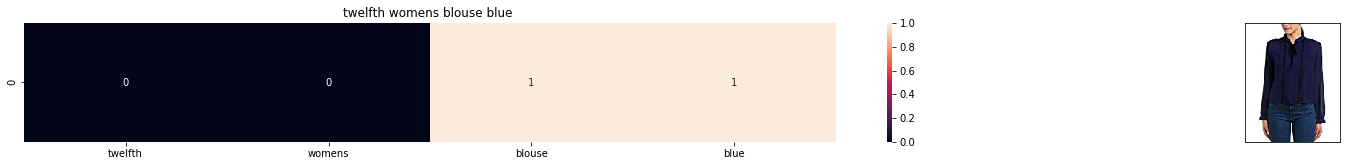

ASIN : B074F5BP5F
Brand: On Twelfth
Title: twelfth womens blouse blue 
Euclidean similarity with the query image : 3.4641016151377544


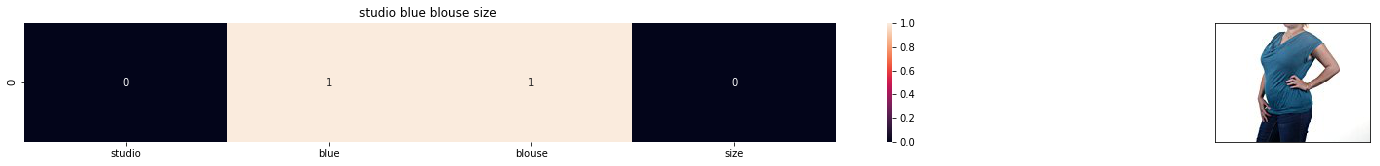

ASIN : B016P80OKQ
Brand: Studio M
Title: studio blue blouse size 
Euclidean similarity with the query image : 3.4641016151377544


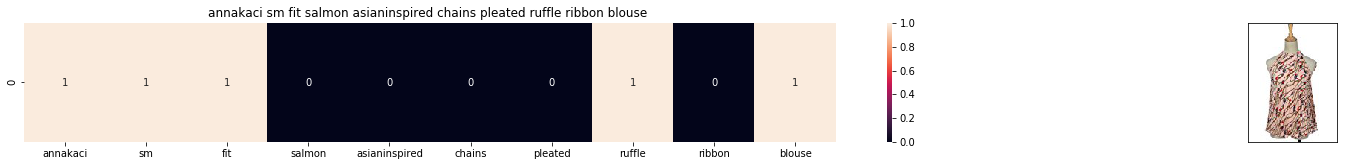

ASIN : B007KSG42S
Brand: Anna-Kaci
Title: annakaci sm fit salmon asianinspired chains pleated ruffle ribbon blouse 
Euclidean similarity with the query image : 3.4641016151377544


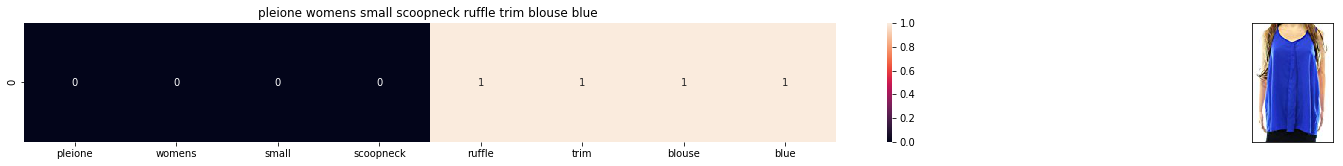

ASIN : B072VHTT1D
Brand: Pleione
Title: pleione womens small scoopneck ruffle trim blouse blue 
Euclidean similarity with the query image : 3.4641016151377544


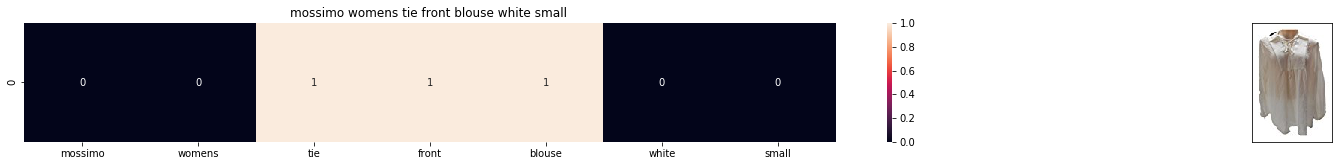

ASIN : B07111HHX6
Brand: Mossimo
Title: mossimo womens tie front blouse white small 
Euclidean similarity with the query image : 3.605551275463989


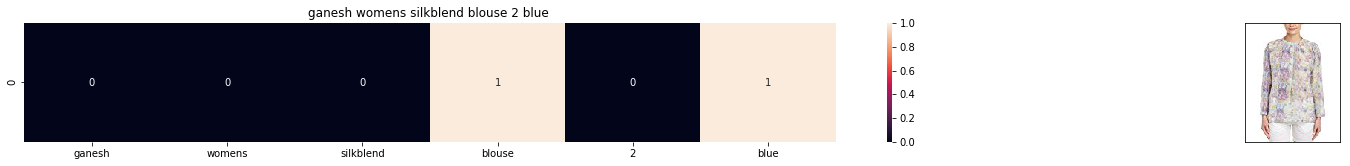

ASIN : B01N3SAT1F
Brand: Ganesh
Title: ganesh womens silkblend blouse 2 blue 
Euclidean similarity with the query image : 3.605551275463989


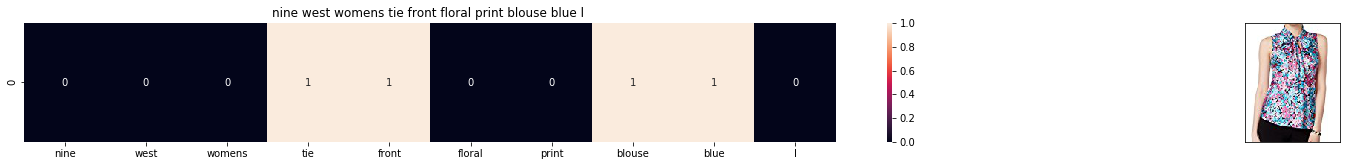

ASIN : B06WW5C6NJ
Brand: Nine West
Title: nine west womens tie front floral print blouse blue l 
Euclidean similarity with the query image : 3.605551275463989


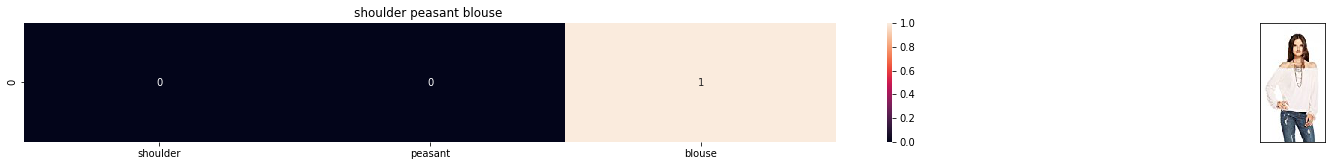

ASIN : B01E1QD5PK
Brand: CHASER
Title: shoulder peasant blouse 
Euclidean similarity with the query image : 3.605551275463989


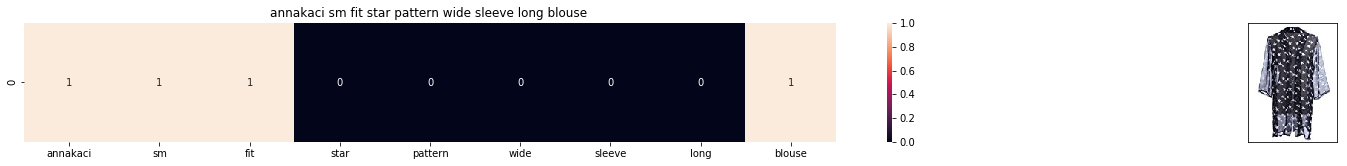

ASIN : B00G5RYY18
Brand: Anna-Kaci
Title: annakaci sm fit star pattern wide sleeve long blouse 
Euclidean similarity with the query image : 3.605551275463989


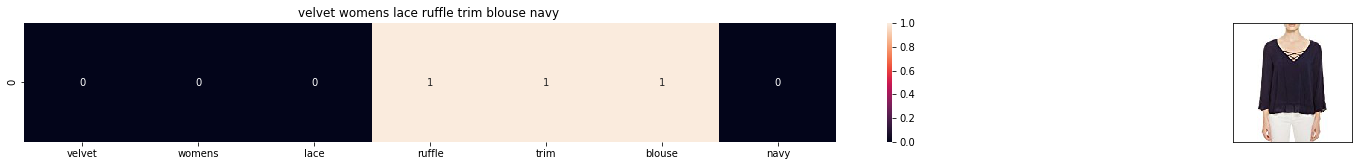

ASIN : B06XCZGQLP
Brand: Velvet by Graham & Spencer
Title: velvet womens lace ruffle trim blouse navy 
Euclidean similarity with the query image : 3.605551275463989


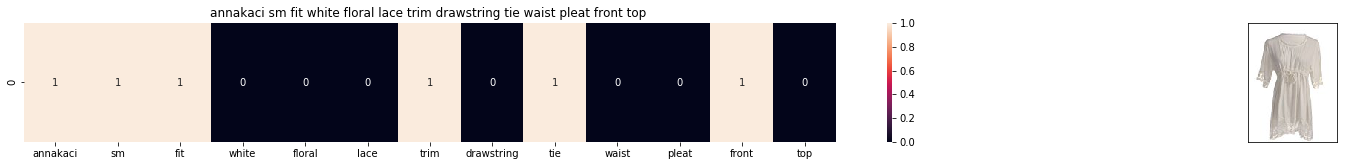

ASIN : B00DW1NKSS
Brand: Anna-Kaci
Title: annakaci sm fit white floral lace trim drawstring tie waist pleat front top 
Euclidean similarity with the query image : 3.605551275463989


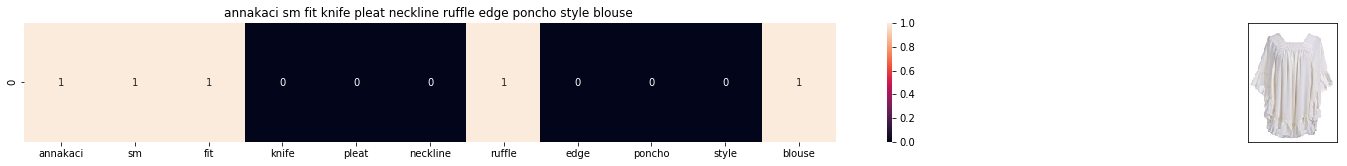

ASIN : B00HCNNOJW
Brand: Anna-Kaci
Title: annakaci sm fit knife pleat neckline ruffle edge poncho style blouse 
Euclidean similarity with the query image : 3.605551275463989


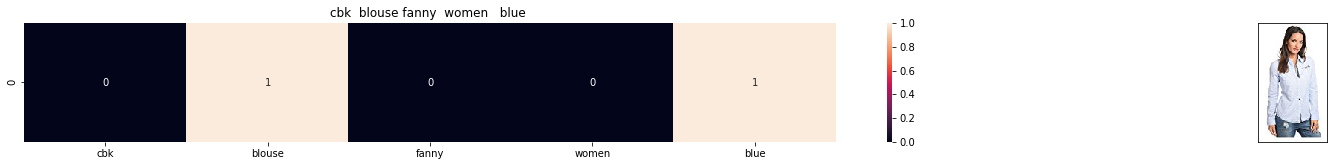

ASIN : B071NDX99J
Brand: CBK
Title: cbk  blouse fanny  women   blue 
Euclidean similarity with the query image : 3.605551275463989


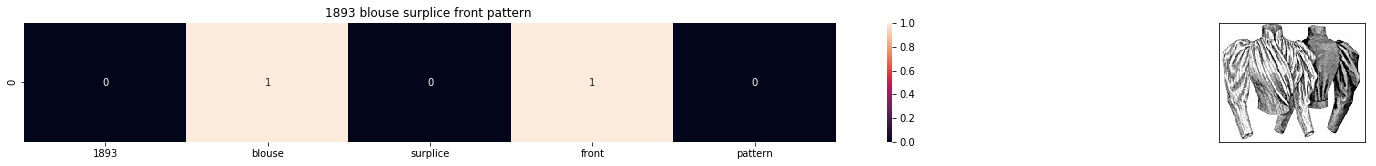

ASIN : B00886YXL0
Brand: Ageless Patterns
Title: 1893 blouse surplice front pattern 
Euclidean similarity with the query image : 3.605551275463989


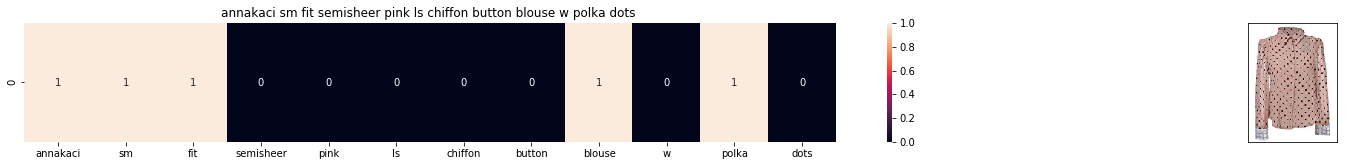

ASIN : B008Z5ST3C
Brand: Anna-Kaci
Title: annakaci sm fit semisheer pink ls chiffon button blouse w polka dots 
Euclidean similarity with the query image : 3.605551275463989


In [17]:
bag_of_words_model(931, 20)

AttributeError: type object 'Image' has no attribute 'open'

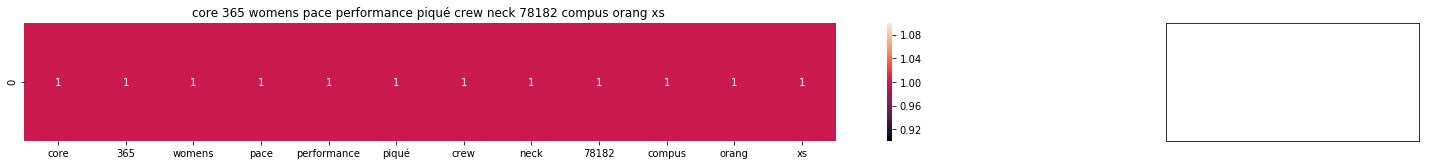

In [42]:
bag_of_words_model(932, 5)

## Also tried:
   1. **Tf-idf model **
   2. **Idf model **

## Model: Word2Vec
- Uses info from text semantics
- Using Google-News-Word2Vec

#### Utility functions for Visulization.

In [10]:
# from gensim.models import Word2Vec
# from gensim.models import KeyedVectors
import pickle

with open('drive-download-files/word2vec_model', 'rb') as handle:
    model = pickle.load(handle)

In [11]:
idf_title_vectorizer = CountVectorizer()
idf_title_features = idf_title_vectorizer.fit_transform(data['title'])

def n_containing(word):
    # return the number of documents which had the given word
    return sum(1 for blob in data['title'] if word in blob.split())

def idf(word):
    # idf = log(#number of docs / #number of docs which had the given word)
    return math.log(data.shape[0] / (n_containing(word)))

# we need to convert the values into float
idf_title_features  = idf_title_features.astype(np.float)

for i in idf_title_vectorizer.vocabulary_.keys():
    # for every word in whole corpus we will find its idf value
    idf_val = idf(i)
    
    # to calculate idf_title_features we need to replace the count values with the idf values of the word
    # idf_title_features[:, idf_title_vectorizer.vocabulary_[i]].nonzero()[0] will return all documents in which the word i present
    for j in idf_title_features[:, idf_title_vectorizer.vocabulary_[i]].nonzero()[0]:
        
        # we replace the count values of word i in document j with  idf_value of word i 
        # idf_title_features[doc_id, index_of_word_in_courpus] = idf value of word
        idf_title_features[j,idf_title_vectorizer.vocabulary_[i]] = idf_val

In [12]:
# Utility functions

def get_word_vec(sentence, doc_id, m_name):
    # sentence : title of the apparel
    # doc_id: document id in our corpus
    # m_name: model information it will take two values
        # if  m_name == 'avg', we will append the model[i], w2v representation of word i
        # if m_name == 'weighted', we will multiply each w2v[word] with the idf(word)
    vec = []
    for i in sentence.split():
        if i in vocab:
            if m_name == 'weighted' and i in  idf_title_vectorizer.vocabulary_:
                vec.append(idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[i]] * model[i])
            elif m_name == 'avg':
                vec.append(model[i])
        else:
            # if the word in our courpus is not there in the google word2vec corpus, we are just ignoring it
            vec.append(np.zeros(shape=(300,)))
    # we will return a numpy array of shape (#number of words in title * 300 ) 300 = len(w2v_model[word])
    # each row represents the word2vec representation of each word (weighted/avg) in given sentance 
    return  np.array(vec)

def get_distance(vec1, vec2):
    # vec1 = np.array(#number_of_words_title1 * 300), each row is a vector of length 300 corresponds to each word in give title
    # vec2 = np.array(#number_of_words_title2 * 300), each row is a vector of length 300 corresponds to each word in give title
    
    final_dist = []
    # for each vector in vec1 we caluclate the distance(euclidean) to all vectors in vec2
    for i in vec1:
        dist = []
        for j in vec2:
            # np.linalg.norm(i-j) will result the euclidean distance between vectors i, j
            dist.append(np.linalg.norm(i-j))
        final_dist.append(np.array(dist))
    # final_dist = np.array(#number of words in title1 * #number of words in title2)
    # final_dist[i,j] = euclidean distance between vectors i, j
    return np.array(final_dist)


def heat_map_w2v(sentence1, sentence2, url, doc_id1, doc_id2, model):
    # sentance1 : title1, input apparel
    # sentance2 : title2, recommended apparel
    # url: apparel image url
    # doc_id1: document id of input apparel
    # doc_id2: document id of recommended apparel
    # model: it can have two values, 1. avg 2. weighted
    
    #s1_vec = np.array(#number_of_words_title1 * 300), each row is a vector(weighted/avg) of length 300 corresponds to each word in give title
    s1_vec = get_word_vec(sentence1, doc_id1, model)
    #s2_vec = np.array(#number_of_words_title1 * 300), each row is a vector(weighted/avg) of length 300 corresponds to each word in give title
    s2_vec = get_word_vec(sentence2, doc_id2, model)

    # s1_s2_dist = np.array(#number of words in title1 * #number of words in title2)
    # s1_s2_dist[i,j] = euclidean distance between words i, j
    s1_s2_dist = get_distance(s1_vec, s2_vec)

    
    
    # devide whole figure into 2 parts 1st part displays heatmap 2nd part displays image of apparel
    gs = gridspec.GridSpec(2, 2, width_ratios=[4,1],height_ratios=[2,1]) 
    fig = plt.figure(figsize=(15,15))
    
    ax = plt.subplot(gs[0])
    # ploting the heap map based on the pairwise distances
    ax = sns.heatmap(np.round(s1_s2_dist,4), annot=True)
    # set the x axis labels as recommended apparels title
    ax.set_xticklabels(sentence2.split())
    # set the y axis labels as input apparels title
    ax.set_yticklabels(sentence1.split())
    # set title as recommended apparels title
    ax.set_title(sentence2)
    
    ax = plt.subplot(gs[1])
    # we remove all grids and axis labels for image
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    display_img(url, ax, fig)
    
    plt.show()


In [13]:
vocab = model.keys()
# this function will add the vectors of each word and returns the avg vector of given sentance
def build_avg_vec(sentence, num_features, doc_id, m_name):
   
    featureVec = np.zeros((num_features,), dtype="float32")
    # we will intialize a vector of size 300 with all zeros
    # we add each word2vec(wordi) to this fetureVec
    nwords = 0
    
    for word in sentence.split():
        nwords += 1
        if word in vocab:
            if m_name == 'weighted' and word in  idf_title_vectorizer.vocabulary_:
                featureVec = np.add(featureVec, idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[word]] * model[word])
            elif m_name == 'avg':
                featureVec = np.add(featureVec, model[word])
    if(nwords>0):
        featureVec = np.divide(featureVec, nwords)
    # returns the avg vector of given sentance, its of shape (1, 300)
    return featureVec

** Average Word2Vec **

......

#### IDF-weighted Word2Vec

In [14]:
doc_id = 0
w2v_title_weight = []
# for every title we build a weighted vector representation
for i in data['title']:
    w2v_title_weight.append(build_avg_vec(i, 300, doc_id,'weighted'))
    doc_id += 1
# w2v_title = np.array(# number of doc in courpus * 300), each row corresponds to a doc 
w2v_title_weight = np.array(w2v_title_weight)

In [15]:
def weighted_w2v_model(doc_id, num_results):
    # doc_id: apparel's id in given corpus
    
    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric we used here is cosine, the coside distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    # http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
    pairwise_dist = pairwise_distances(w2v_title_weight, w2v_title_weight[doc_id].reshape(1,-1))

    # np.argsort will return indices of 9 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the 9 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])
    
    for i in range(0, len(indices)):
        heat_map_w2v(data['title'].loc[df_indices[0]],data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], indices[0], indices[i], 'weighted')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('Brand :',data['brand'].loc[df_indices[i]])
        print('euclidean distance from input :', pdists[i])
        print('='*125)

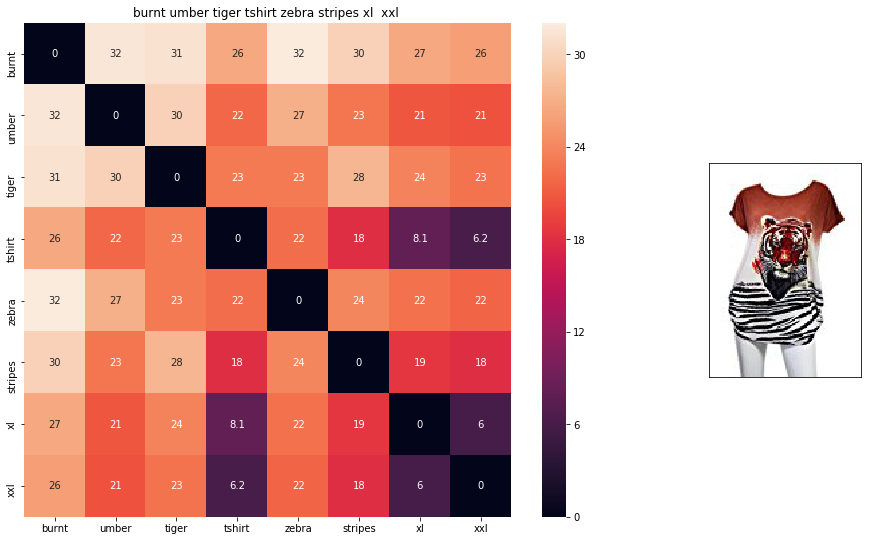

ASIN : B00JXQB5FQ
Brand : Si Row
euclidean distance from input : 0.0055242716


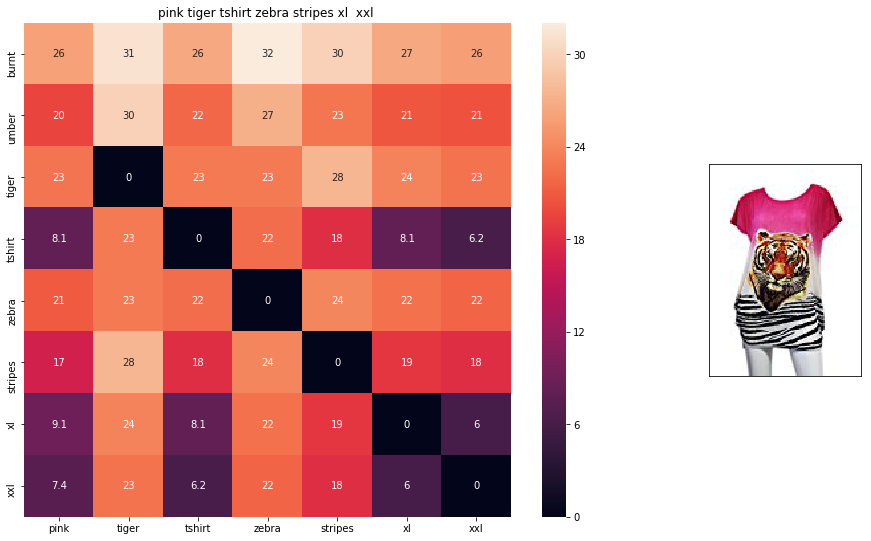

ASIN : B00JXQASS6
Brand : Si Row
euclidean distance from input : 4.0638876


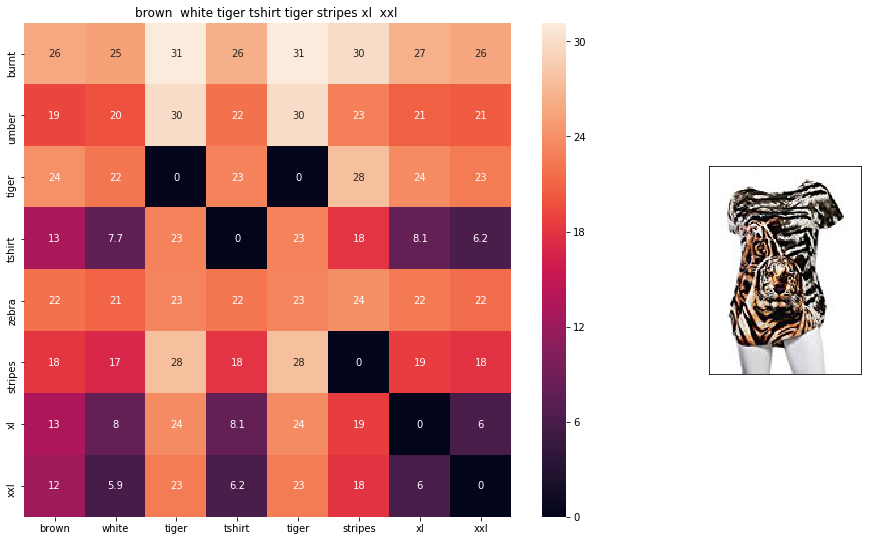

ASIN : B00JXQCWTO
Brand : Si Row
euclidean distance from input : 4.770943


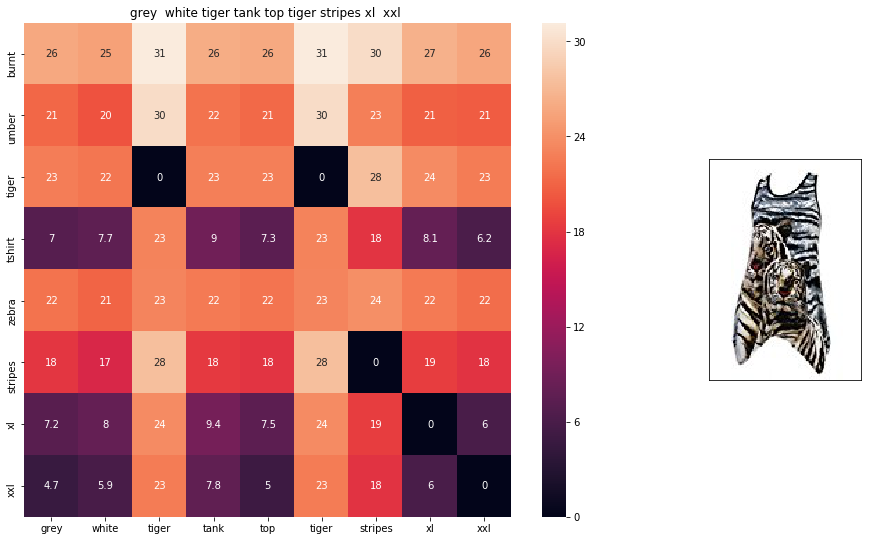

ASIN : B00JXQAFZ2
Brand : Si Row
euclidean distance from input : 5.360161


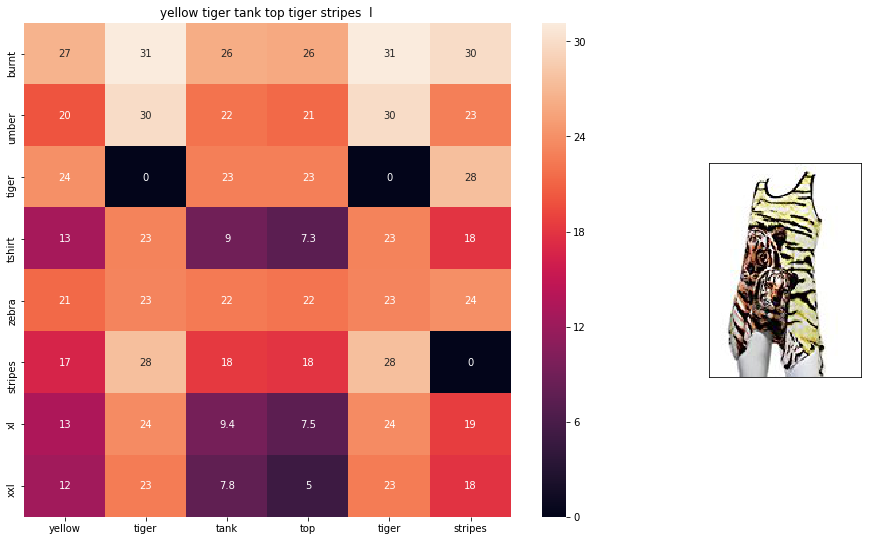

ASIN : B00JXQAUWA
Brand : Si Row
euclidean distance from input : 5.689523


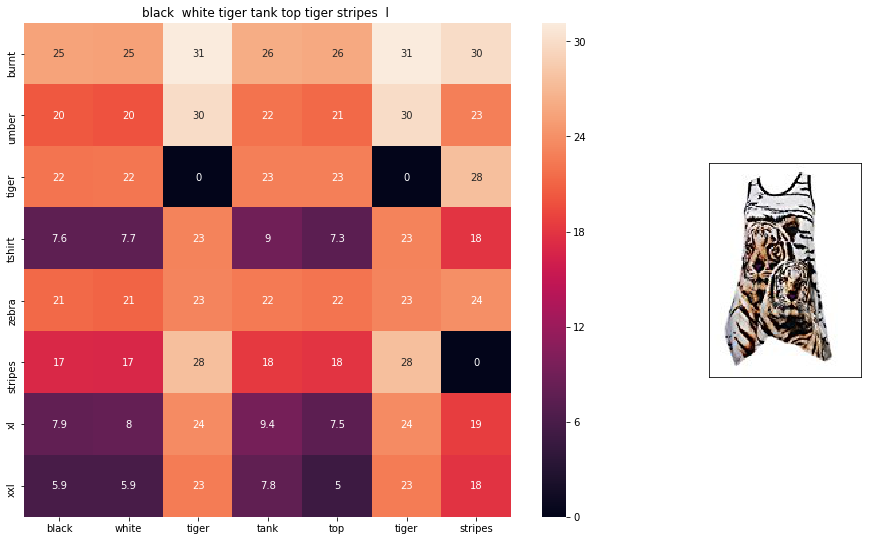

ASIN : B00JXQAO94
Brand : Si Row
euclidean distance from input : 5.693022


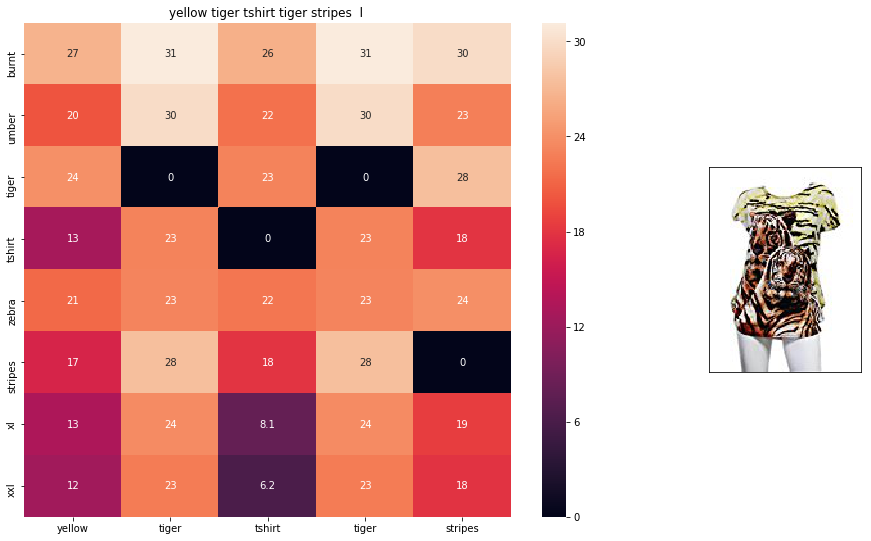

ASIN : B00JXQCUIC
Brand : Si Row
euclidean distance from input : 5.893444


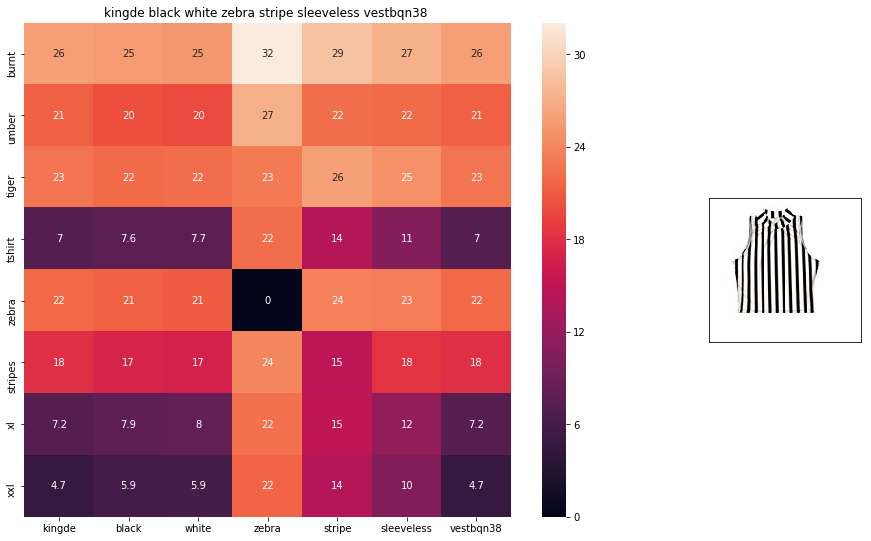

ASIN : B015H41F6G
Brand : KINGDE
euclidean distance from input : 6.13299


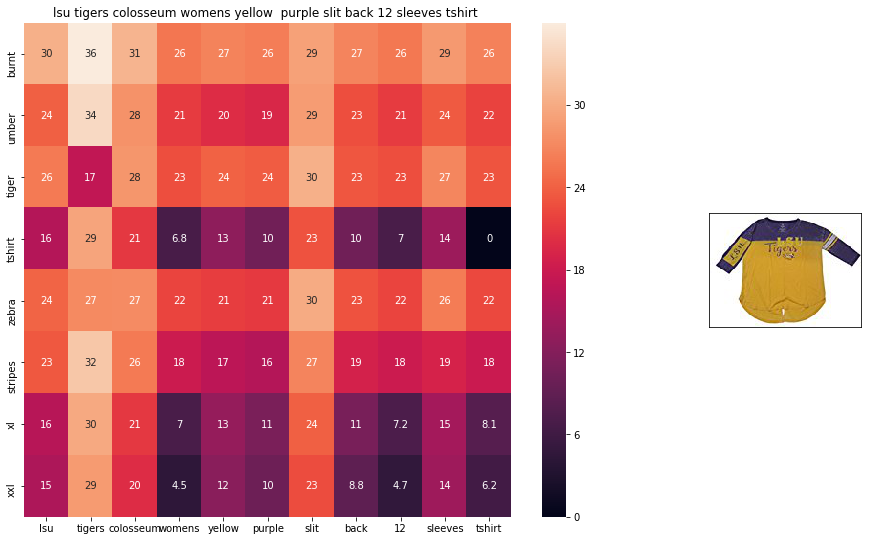

ASIN : B073R5Q8HD
Brand : Colosseum
euclidean distance from input : 6.2567058


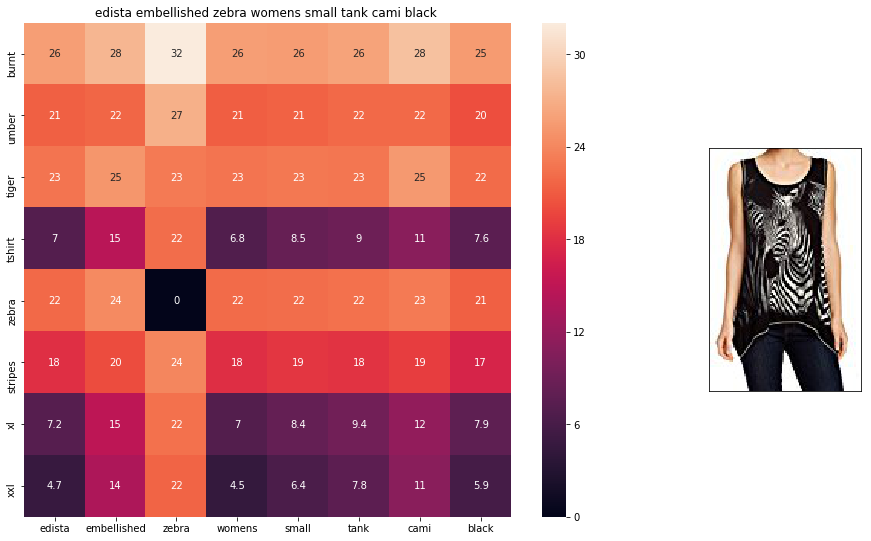

ASIN : B074P8MD22
Brand : Edista
euclidean distance from input : 6.3922043


In [17]:
weighted_w2v_model(12566, 10)

#### Weighted Similarity using *Brand* and *Colour*

In [36]:
from scipy.sparse import hstack
import plotly
import plotly.figure_factory as ff

In [24]:
# some of the brand values are empty. 
# Need to replace Null with string "NULL"
data['brand'].fillna(value="Not given", inplace=True )

# replace spaces with hypen
brands = [x.replace(" ", "-") for x in data['brand'].values]
types = [x.replace(" ", "-") for x in data['product_type_name'].values]
colors = [x.replace(" ", "-") for x in data['color'].values]

brand_vectorizer = CountVectorizer()
brand_features = brand_vectorizer.fit_transform(brands)

type_vectorizer = CountVectorizer()
type_features = type_vectorizer.fit_transform(types)

color_vectorizer = CountVectorizer()
color_features = color_vectorizer.fit_transform(colors)

extra_features = hstack((brand_features, type_features, color_features)).tocsr()

In [37]:
def heat_map_w2v_brand(sentance1, sentance2, url, doc_id1, doc_id2, df_id1, df_id2, model):
    
    # sentance1 : title1, input apparel
    # sentance2 : title2, recommended apparel
    # url: apparel image url
    # doc_id1: document id of input apparel
    # doc_id2: document id of recommended apparel
    # df_id1: index of document1 in the data frame
    # df_id2: index of document2 in the data frame
    # model: it can have two values, 1. avg 2. weighted
    
    #s1_vec = np.array(#number_of_words_title1 * 300), each row is a vector(weighted/avg) of length 300 corresponds to each word in give title
    s1_vec = get_word_vec(sentance1, doc_id1, model)
    #s2_vec = np.array(#number_of_words_title2 * 300), each row is a vector(weighted/avg) of length 300 corresponds to each word in give title
    s2_vec = get_word_vec(sentance2, doc_id2, model)
    
    # s1_s2_dist = np.array(#number of words in title1 * #number of words in title2)
    # s1_s2_dist[i,j] = euclidean distance between words i, j
    s1_s2_dist = get_distance(s1_vec, s2_vec)
   
    data_matrix = [['Asin','Brand', 'Color', 'Product type'],
               [data['asin'].loc[df_id1],brands[doc_id1], colors[doc_id1], types[doc_id1]], # input apparel's features
               [data['asin'].loc[df_id2],brands[doc_id2], colors[doc_id2], types[doc_id2]]] # recommonded apparel's features
    
    colorscale = [[0, '#1d004d'],[.5, '#f2e5ff'],[1, '#f2e5d1']] # to color the headings of each column 
    
    # we create a table with the data_matrix
    table = ff.create_table(data_matrix, index=True, colorscale=colorscale)
    # plot it with plotly
    plotly.offline.iplot(table, filename='simple_table')
    
    # devide whole figure space into 25 * 1:10 grids
    gs = gridspec.GridSpec(25, 15)
    fig = plt.figure(figsize=(25,5))
    
    # in first 25*10 grids we plot heatmap
    ax1 = plt.subplot(gs[:, :-5])
    # ploting the heap map based on the pairwise distances
    ax1 = sns.heatmap(np.round(s1_s2_dist,6), annot=True)
    # set the x axis labels as recommended apparels title
    ax1.set_xticklabels(sentance2.split())
    # set the y axis labels as input apparels title
    ax1.set_yticklabels(sentance1.split())
    # set title as recommended apparels title
    ax1.set_title(sentance2)

    # in last 25 * 10:15 grids we display image
    ax2 = plt.subplot(gs[:, 10:16])
    # we dont display grid lins and axis labels to images
    ax2.grid(False)
    ax2.set_xticks([])
    ax2.set_yticks([])
    
    # pass the url it display it
    display_img(url, ax2, fig)
    
    plt.show()

In [30]:
def idf_w2v_brand(doc_id, w1, w2, num_results):
   
    idf_w2v_dist  = pairwise_distances(w2v_title_weight, w2v_title_weight[doc_id].reshape(1,-1))
    ex_feat_dist = pairwise_distances(extra_features, extra_features[doc_id])
    pairwise_dist   = (w1 * idf_w2v_dist +  w2 * ex_feat_dist)/float(w1 + w2)

    # np.argsort will return indices of 9 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the 9 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])
    

    for i in range(0, len(indices)):
        heat_map_w2v_brand(data['title'].loc[df_indices[0]],data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], indices[0], indices[i],df_indices[0], df_indices[i], 'weighted')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('Brand :',data['brand'].loc[df_indices[i]])
        print('euclidean distance from input :', pdists[i])
        print('='*125)

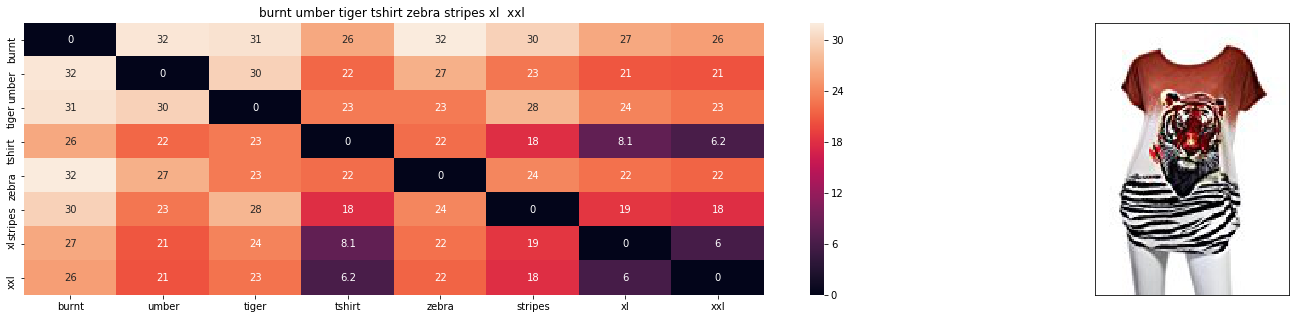

ASIN : B00JXQB5FQ
Brand : Si Row
euclidean distance from input : 0.002762135863304138


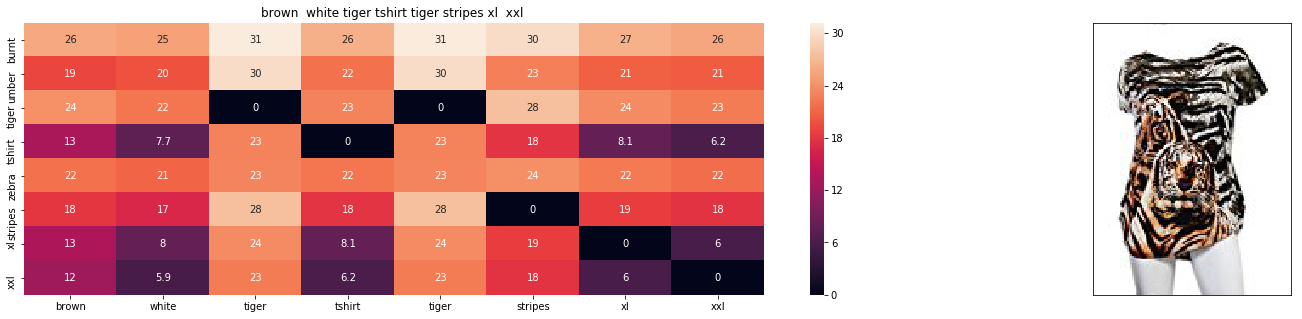

ASIN : B00JXQCWTO
Brand : Si Row
euclidean distance from input : 2.385471534729004


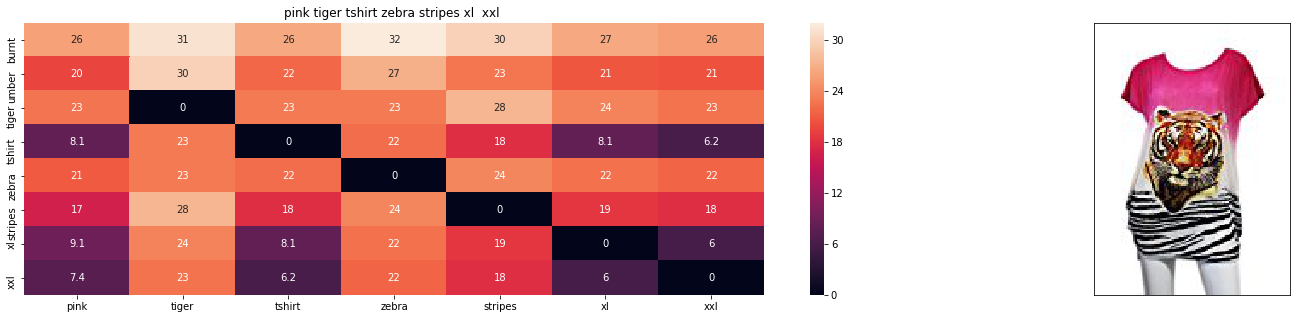

ASIN : B00JXQASS6
Brand : Si Row
euclidean distance from input : 2.7390506746191647


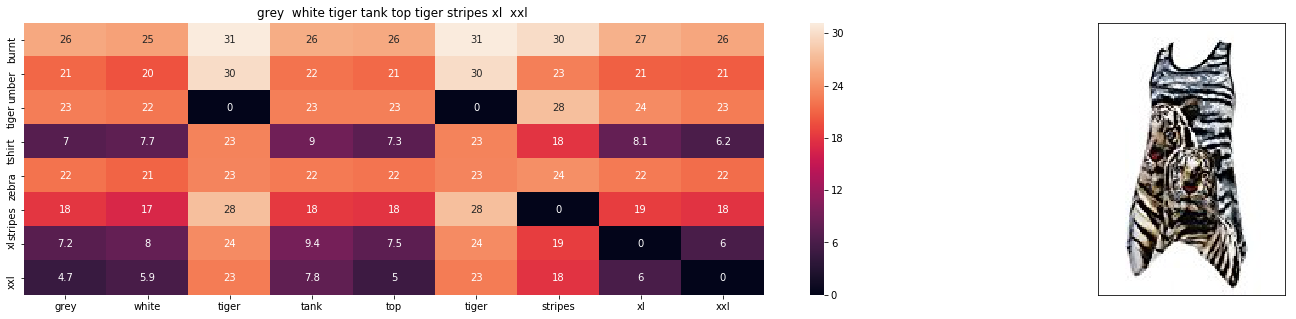

ASIN : B00JXQAFZ2
Brand : Si Row
euclidean distance from input : 3.387187195004907


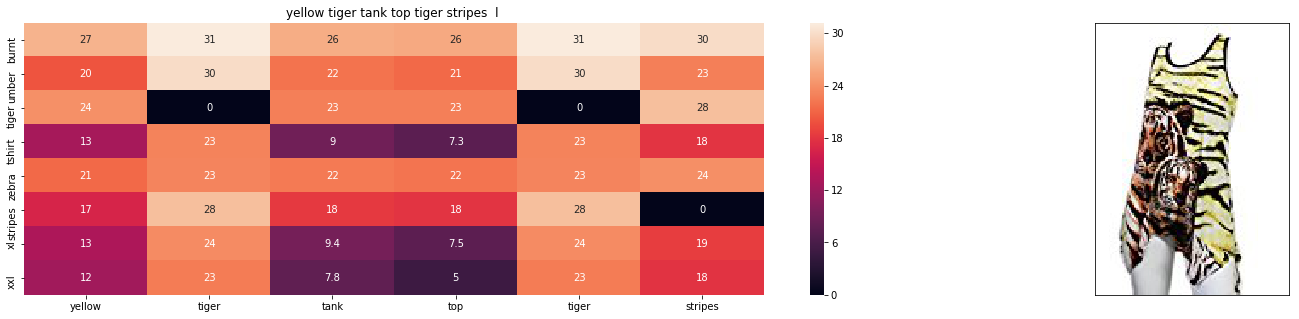

ASIN : B00JXQAUWA
Brand : Si Row
euclidean distance from input : 3.5518684389013915


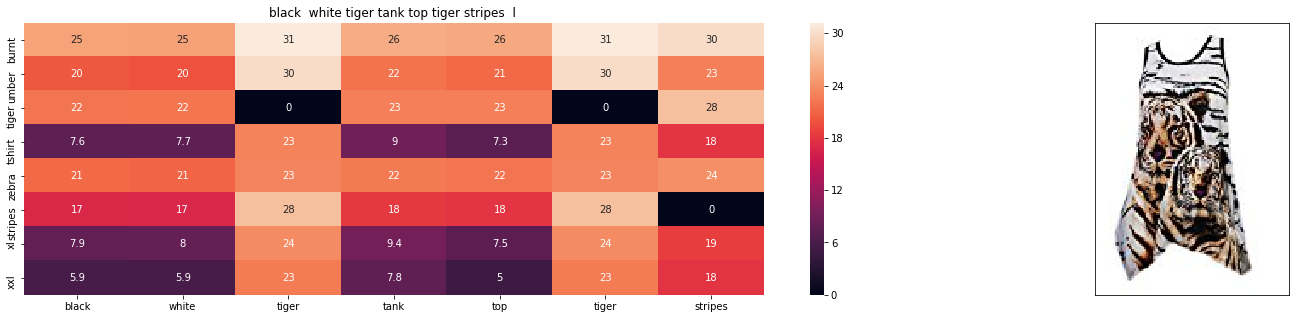

ASIN : B00JXQAO94
Brand : Si Row
euclidean distance from input : 3.5536176683325436


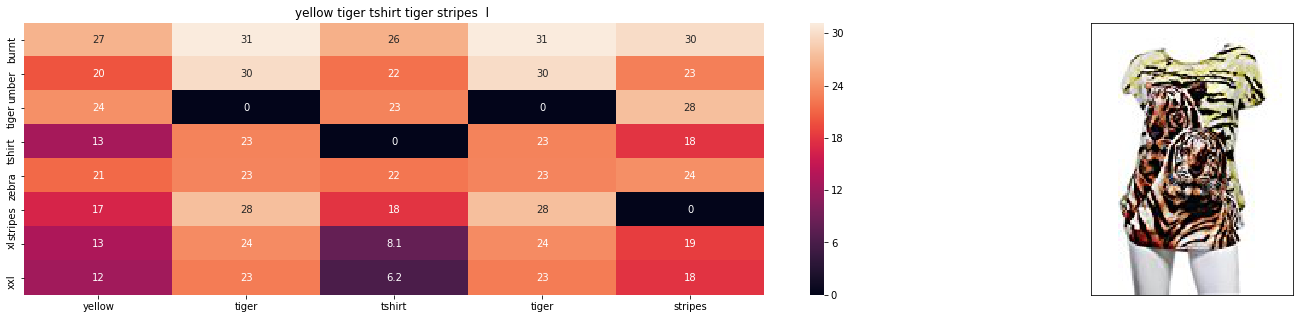

ASIN : B00JXQCUIC
Brand : Si Row
euclidean distance from input : 3.653828811826196


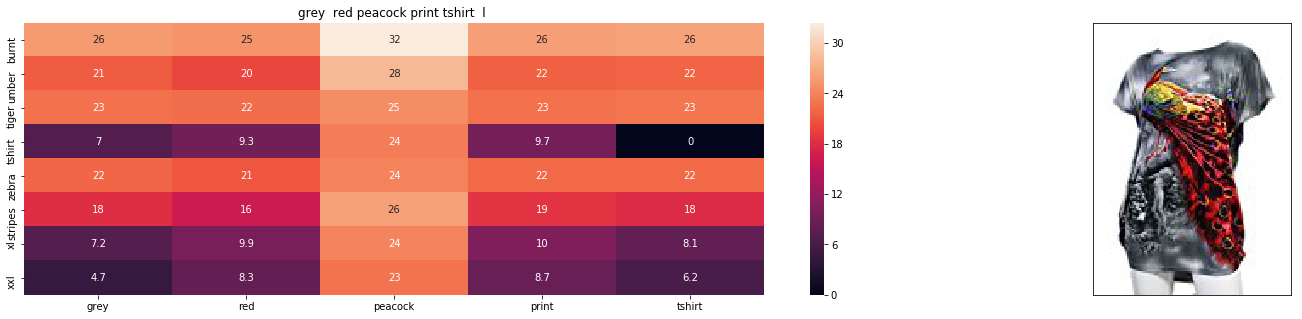

ASIN : B00JXQCFRS
Brand : Si Row
euclidean distance from input : 4.128811645688501


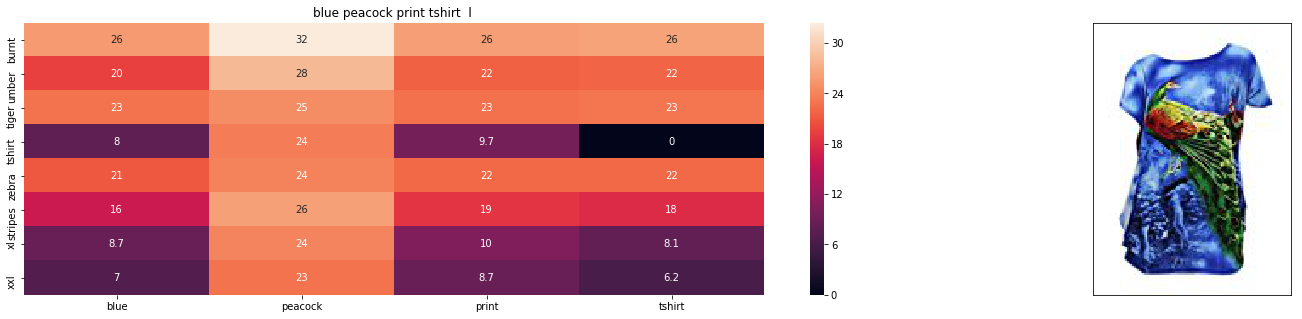

ASIN : B00JXQC8L6
Brand : Si Row
euclidean distance from input : 4.203900146665063


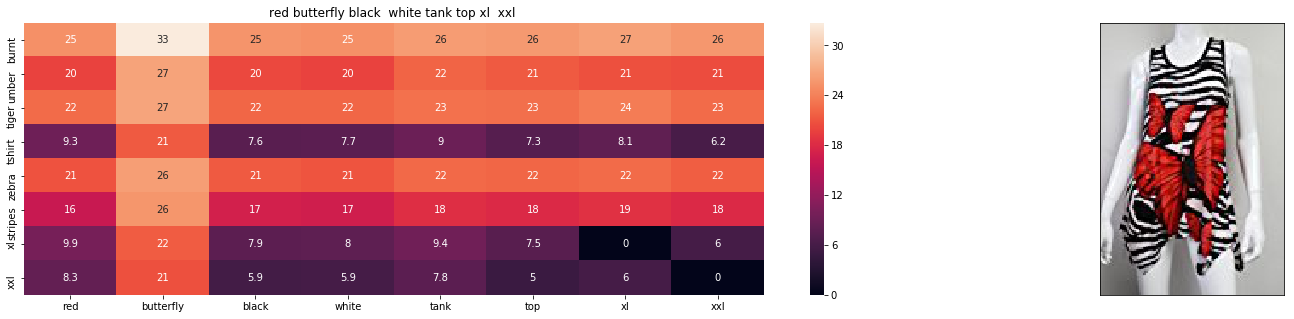

ASIN : B00JV63CW2
Brand : Si Row
euclidean distance from input : 4.286586380185571


In [38]:
idf_w2v_brand(12566, 5, 5, 10)

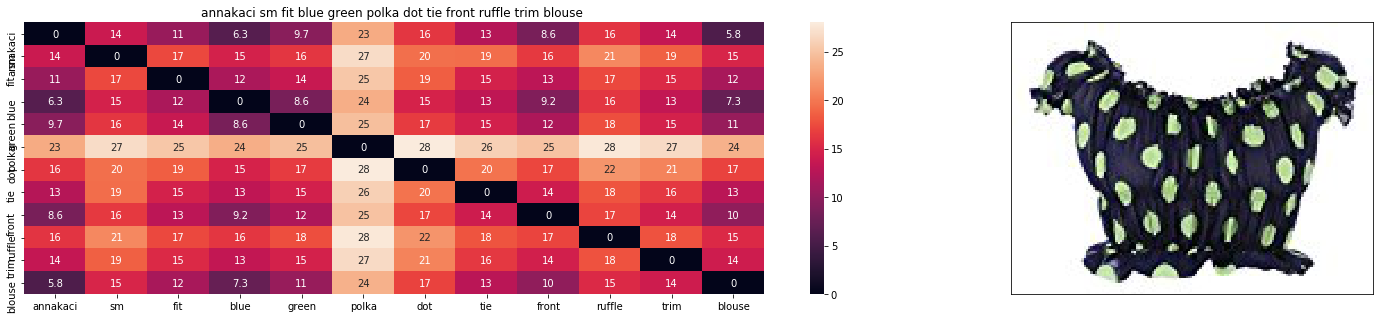

ASIN : B00KLHUIBS
Brand : Anna-Kaci
euclidean distance from input : 0.0


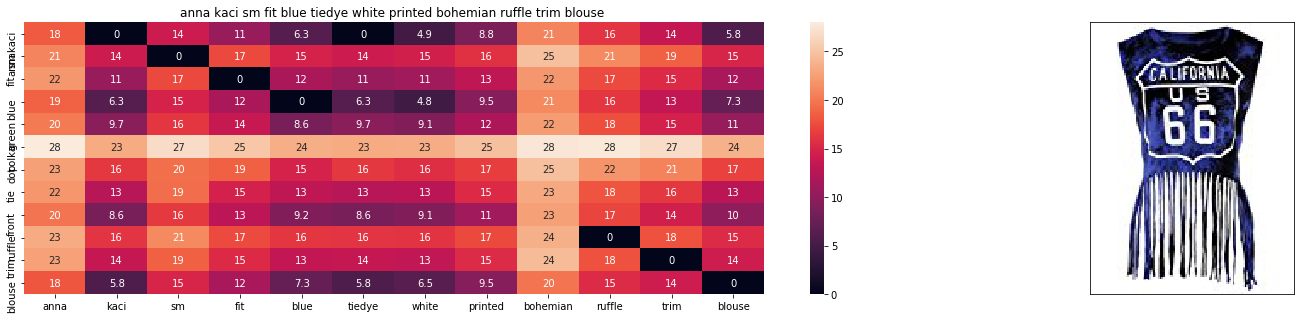

ASIN : B00YQ8S4K0
Brand : Anna-Kaci
euclidean distance from input : 2.2096765518188475


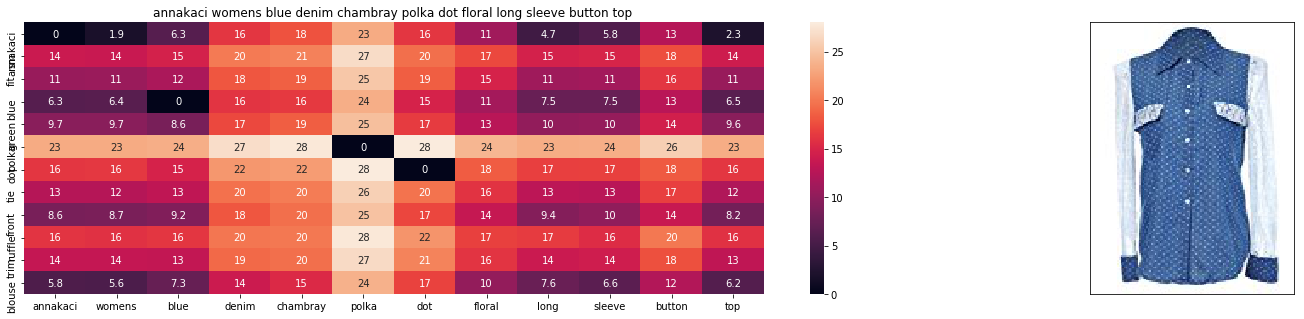

ASIN : B008SMIFN6
Brand : Anna-Kaci
euclidean distance from input : 2.341132164001465


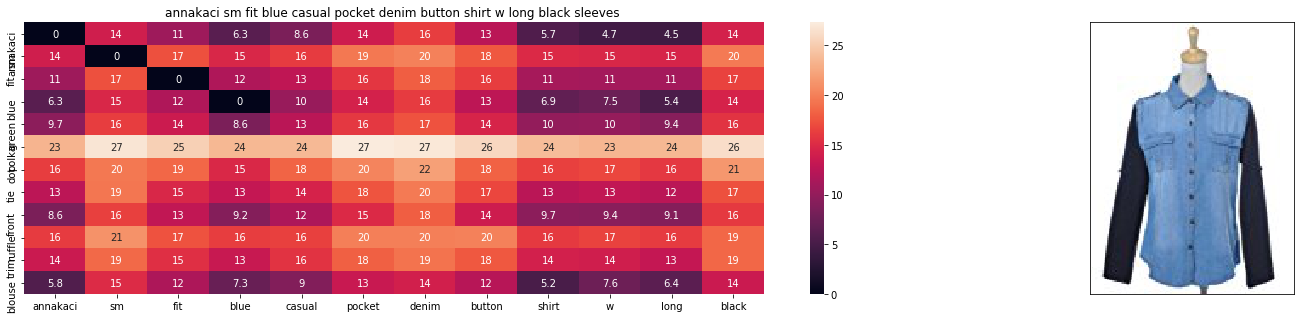

ASIN : B0097LQOOY
Brand : Anna-Kaci
euclidean distance from input : 2.523504066467285


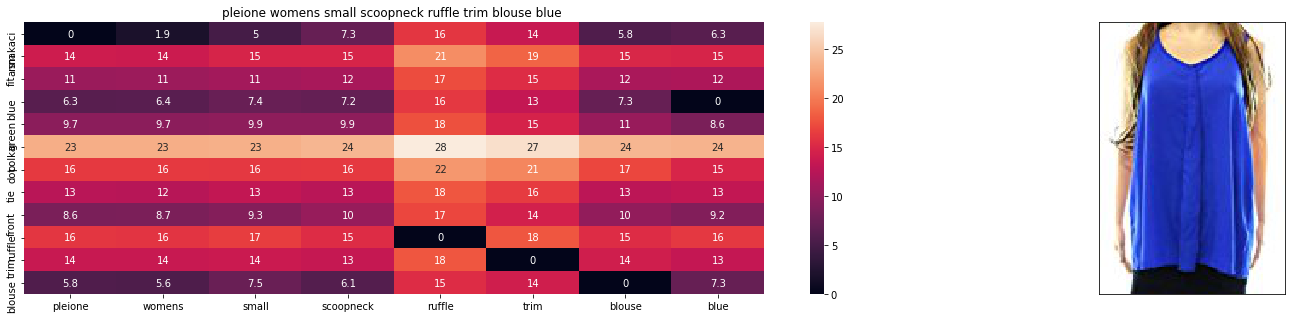

ASIN : B072VHTT1D
Brand : Pleione
euclidean distance from input : 2.652312088012695


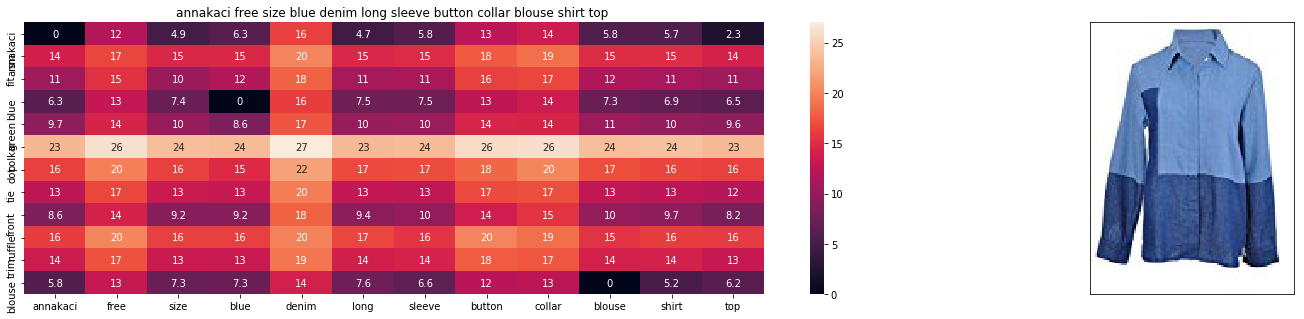

ASIN : B00726I25U
Brand : Anna-Kaci
euclidean distance from input : 2.6782474517822266


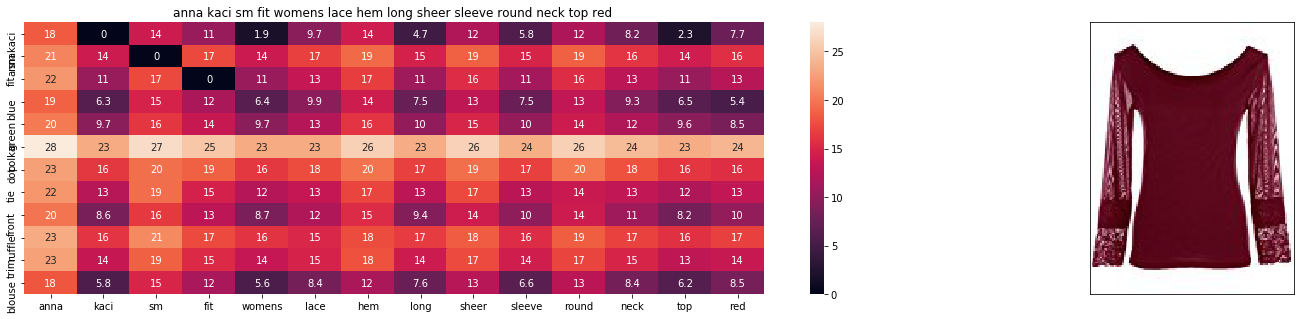

ASIN : B019XS6OLS
Brand : Anna-Kaci
euclidean distance from input : 2.7675749338137354


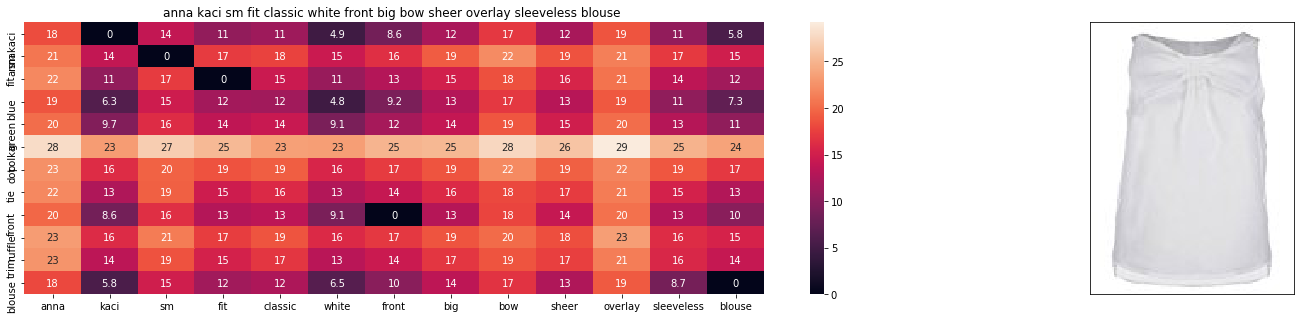

ASIN : B010EH3S02
Brand : Anna-Kaci
euclidean distance from input : 2.8144186532961575


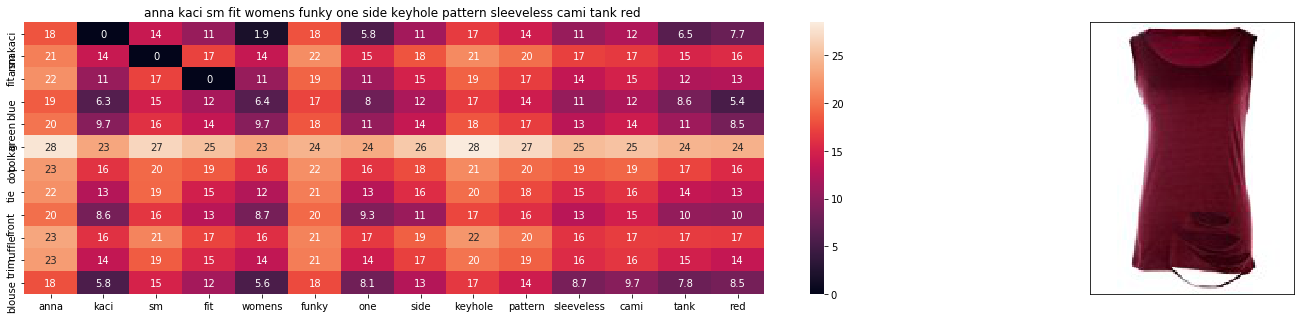

ASIN : B019NQLRF8
Brand : Anna-Kaci
euclidean distance from input : 2.8479425943361965


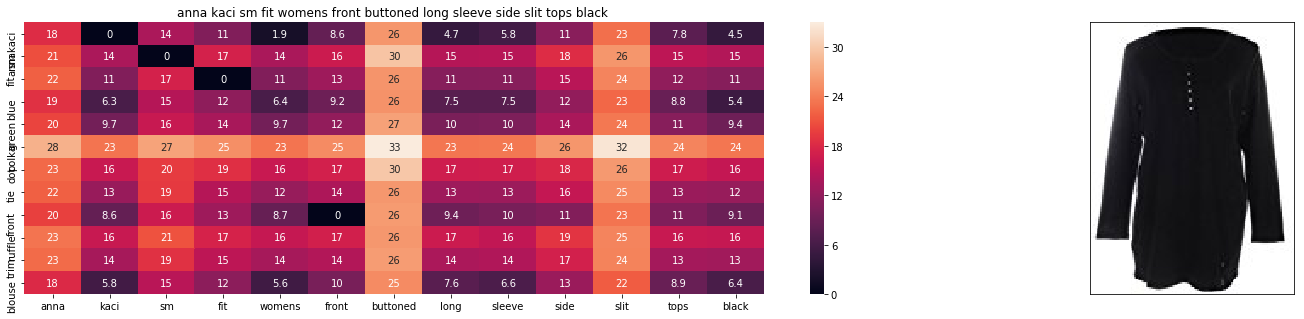

ASIN : B019820A4Q
Brand : Anna-Kaci
euclidean distance from input : 2.87321019534938


In [80]:
idf_w2v_brand(931,5,5,10)

### Visual feature based similarity

In [40]:
#load the features and corresponding ASINS info.
bottleneck_features_train = np.load('drive-download-files/16k_data_cnn_features.npy')
asins = np.load('drive-download-files/16k_data_cnn_feature_asins.npy')
asins = list(asins)

# load the original 16K dataset
data = pd.read_pickle('pickels/16k_apperal_data_preprocessed')
df_asins = list(data['asin'])

from IPython.display import display, Image, SVG, Math, YouTubeVideo

#get similar products using CNN features (VGG-16)
def get_similar_products_cnn(doc_id, num_results):
    doc_id = asins.index(df_asins[doc_id])
    pairwise_dist = pairwise_distances(bottleneck_features_train, bottleneck_features_train[doc_id].reshape(1,-1))

    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    for i in range(len(indices)):
        rows = data[['medium_image_url','title']].loc[data['asin']==asins[indices[i]]]
        for indx, row in rows.iterrows():
            display(Image(url=row['medium_image_url'], embed=True))
            print('Product Title: ', row['title'])
            print('Euclidean Distance from input image:', pdists[i])
            print('Amazon Url: www.amzon.com/dp/'+ asins[indices[i]])

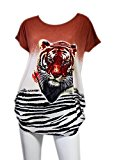

Product Title:  burnt umber tiger tshirt zebra stripes xl  xxl 
Euclidean Distance from input image: 0.0
Amazon Url: www.amzon.com/dp/B00JXQB5FQ


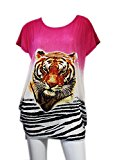

Product Title:  pink tiger tshirt zebra stripes xl  xxl 
Euclidean Distance from input image: 30.050104
Amazon Url: www.amzon.com/dp/B00JXQASS6


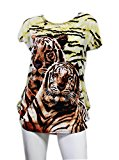

Product Title:  yellow tiger tshirt tiger stripes  l 
Euclidean Distance from input image: 41.261078
Amazon Url: www.amzon.com/dp/B00JXQCUIC


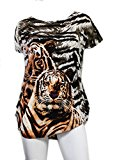

Product Title:  brown  white tiger tshirt tiger stripes xl  xxl 
Euclidean Distance from input image: 44.000156
Amazon Url: www.amzon.com/dp/B00JXQCWTO


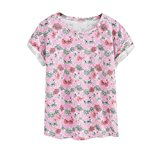

Product Title:  kawaii pastel tops tees pink flower design 
Euclidean Distance from input image: 47.382523
Amazon Url: www.amzon.com/dp/B071FCWD97


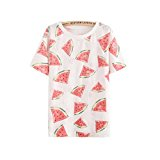

Product Title:  womens thin style tops tees pastel watermelon print 
Euclidean Distance from input image: 47.718403
Amazon Url: www.amzon.com/dp/B01JUNHBRM


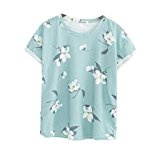

Product Title:  kawaii pastel tops tees baby blue flower design 
Euclidean Distance from input image: 47.902122
Amazon Url: www.amzon.com/dp/B071SBCY9W


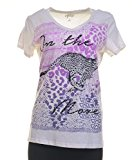

Product Title:  edv cheetah run purple multi xl 
Euclidean Distance from input image: 48.046516
Amazon Url: www.amzon.com/dp/B01CUPYBM0


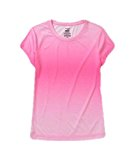

Product Title:  danskin womens vneck loose performance tee xsmall pink ombre 
Euclidean Distance from input image: 48.101906
Amazon Url: www.amzon.com/dp/B01F7PHXY8


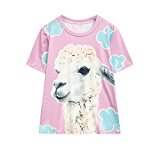

Product Title:  summer alpaca 3d pastel casual loose tops tee design 
Euclidean Distance from input image: 48.118877
Amazon Url: www.amzon.com/dp/B01I80A93G


In [41]:
get_similar_products_cnn(12566, 10)

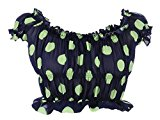

Product Title:  annakaci sm fit blue green polka dot tie front ruffle trim blouse 
Euclidean Distance from input image: 0.069877125
Amazon Url: www.amzon.com/dp/B00KLHUIBS


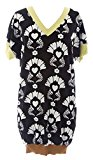

Product Title:  eternal child womens black floral printed vneck short sleeve tunic sz new 
Euclidean Distance from input image: 47.391525
Amazon Url: www.amzon.com/dp/B0184RPZNM


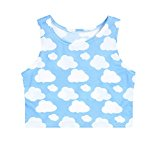

Product Title:  harajuku cloud printed elastic crop tops women 
Euclidean Distance from input image: 48.21547
Amazon Url: www.amzon.com/dp/B01KQHFVP0


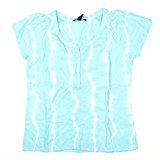

Product Title:  bandolino womens erin round v neck tie dyed shirt top small aqua refelction 
Euclidean Distance from input image: 48.509605
Amazon Url: www.amzon.com/dp/B00ROB8A8W


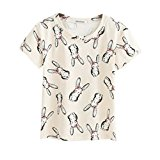

Product Title:  new kawaii cotton pastel tops tees rabbit design 
Euclidean Distance from input image: 48.602066
Amazon Url: www.amzon.com/dp/B074S5F9ZK


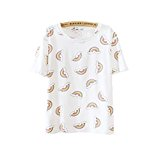

Product Title:  cute womens tops tees pastel rainbow print size 
Euclidean Distance from input image: 48.698795
Amazon Url: www.amzon.com/dp/B01415UNVU


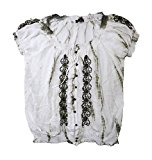

Product Title:  fever ladies size small rayon blouse white  green 
Euclidean Distance from input image: 48.72842
Amazon Url: www.amzon.com/dp/B0731PMQZ2


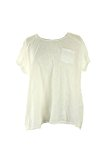

Product Title:  style  co plus size new whit cuffed shortsleeve tee 2x 1498 dbfl 
Euclidean Distance from input image: 48.86424
Amazon Url: www.amzon.com/dp/B0178WOJVS


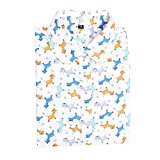

Product Title:  women blouses turn collar floral tops lady long sleeve shirt sxxxxl 
Euclidean Distance from input image: 48.973186
Amazon Url: www.amzon.com/dp/B07552VG9B


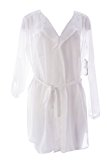

Product Title:  miraclebody miraclesuit womens roll sleeve long tunic sz medium ivory 
Euclidean Distance from input image: 49.009098
Amazon Url: www.amzon.com/dp/B01MUF826N


In [43]:
get_similar_products_cnn(931, 10)

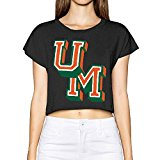

Product Title:  women bare midriff crop top university miami logo athletics 
Euclidean Distance from input image: 0.0
Amazon Url: www.amzon.com/dp/B01G4OEW1S


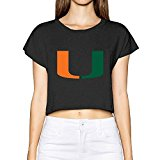

Product Title:  womens top bare midriffs university miami logo um football 
Euclidean Distance from input image: 29.112272
Amazon Url: www.amzon.com/dp/B01G4OEITE


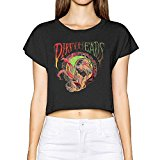

Product Title:  dirty heads band cabin sea garland woman graphicprint treasures crop tee 
Euclidean Distance from input image: 30.8141
Amazon Url: www.amzon.com/dp/B01HO12CR6


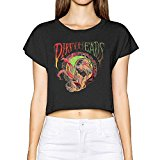

Product Title:  dirty heads band cabin sea garland womens graphicprint treasures cropped shirt 
Euclidean Distance from input image: 30.8141
Amazon Url: www.amzon.com/dp/B01HO12FP0


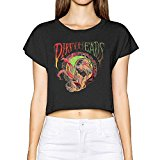

Product Title:  dirty heads band cabin sea garland womens graphicprint classic bare midriff 
Euclidean Distance from input image: 30.8141
Amazon Url: www.amzon.com/dp/B01HO12H9E


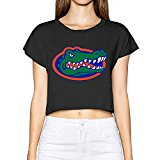

Product Title:  womens bare midriff crop top university florida logo gators 
Euclidean Distance from input image: 31.37198
Amazon Url: www.amzon.com/dp/B01G4OF32U


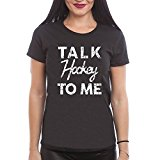

Product Title:  talk hockey shirts womens xxxl black 
Euclidean Distance from input image: 44.75121
Amazon Url: www.amzon.com/dp/B01I6DXI7E


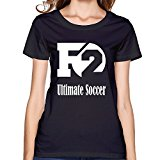

Product Title:  f2 freestylers ultimate soccer woman black short sleeve tshirt 
Euclidean Distance from input image: 44.845535
Amazon Url: www.amzon.com/dp/B01J6WYQ48


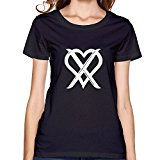

Product Title:  womens 7 ronaldo quotes love win tshirts xxl black short sleeve 
Euclidean Distance from input image: 45.365273
Amazon Url: www.amzon.com/dp/B01JSLCWXO


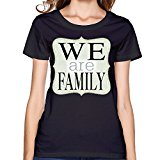

Product Title:  fashion womens family tshirts black size xs 
Euclidean Distance from input image: 46.080135
Amazon Url: www.amzon.com/dp/B01IY8UHMA


In [45]:
get_similar_products_cnn(93, 10)

### Weighted Similarity using Title, Brand, Colour and Image

In [107]:
def idf_w2v_brand_image(doc_id, w_t, w_b, w_c, w_i, num_results):

    idf_w2v_dist  = pairwise_distances(w2v_title_weight, w2v_title_weight[doc_id].reshape(1,-1))
    brand_feat_dist = pairwise_distances(brand_features, brand_features[doc_id])
    color_feat_dist = pairwise_distances(color_features, color_features[doc_id])
    image_feat_dist = pairwise_distances(bottleneck_features_train, bottleneck_features_train[doc_id].reshape(1,-1))
    
    pairwise_dist   = (w_t * idf_w2v_dist +  w_b * brand_feat_dist + w_c * color_feat_dist + w_i * image_feat_dist)/float(w_t + w_b + w_c + w_i)

    # np.argsort will return indices of 9 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the 9 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])

    for i in range(0, len(indices)):
        heat_map_w2v_brand(data['title'].loc[df_indices[0]],data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], indices[0], indices[i],df_indices[0], df_indices[i], 'weighted')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('Brand :',data['brand'].loc[df_indices[i]])
        print('euclidean distance from input :', pdists[i])
        print('='*125)

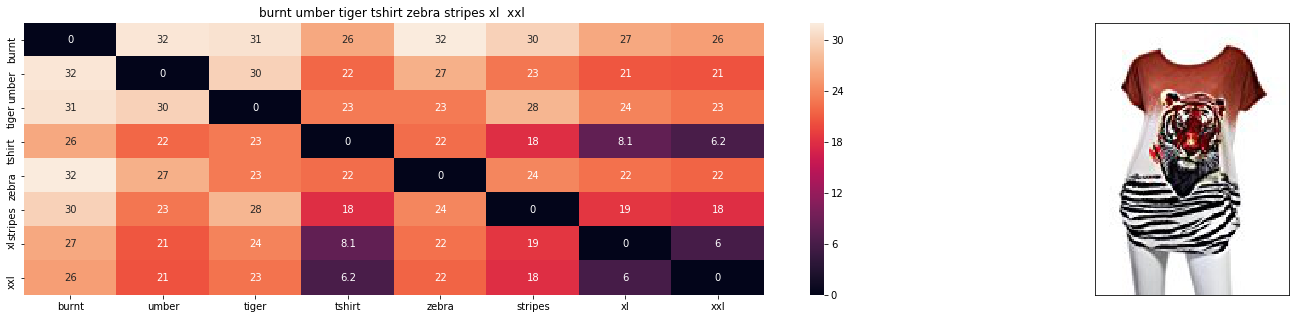

ASIN : B00JXQB5FQ
Brand : Si Row
euclidean distance from input : 0.0038244957462526285


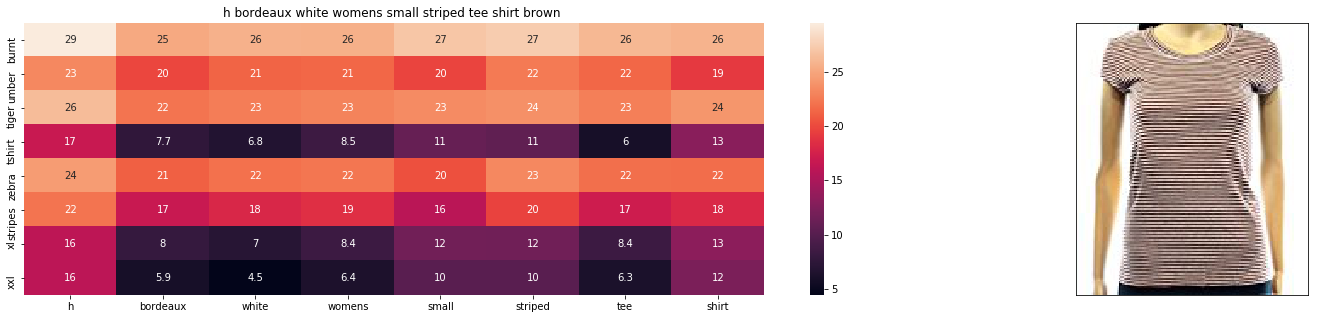

ASIN : B072BVB47Z
Brand : H By Bordeaux
euclidean distance from input : 4.217422888829158


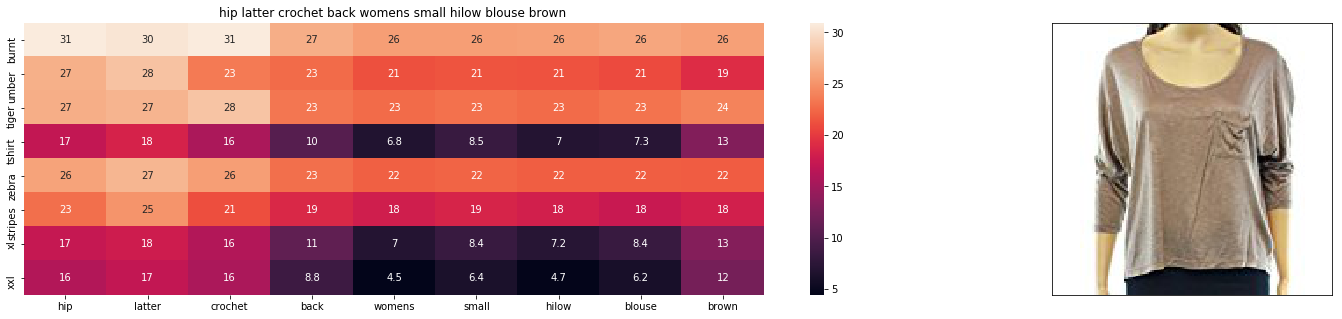

ASIN : B074MJN1K9
Brand : Hip
euclidean distance from input : 4.275193794514387


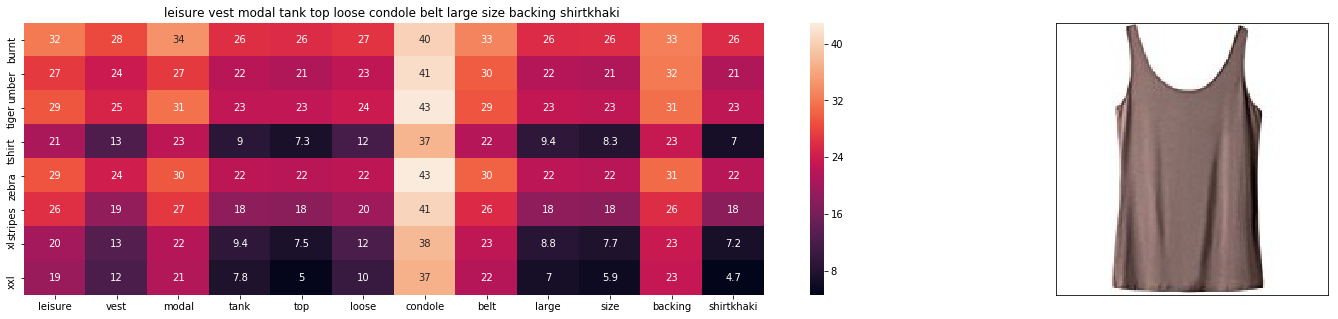

ASIN : B014OUHUZY
Brand : Black Temptation
euclidean distance from input : 4.488374196566069


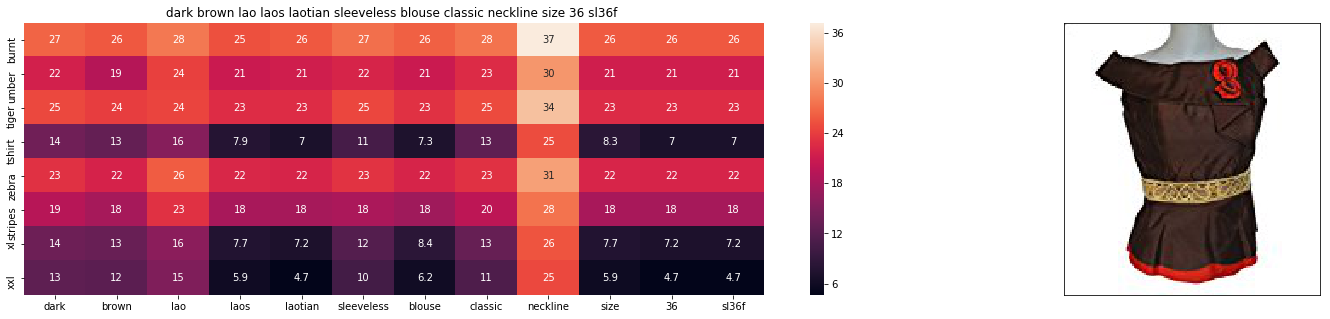

ASIN : B074J7BCYM
Brand : Nanon
euclidean distance from input : 4.601975544239729


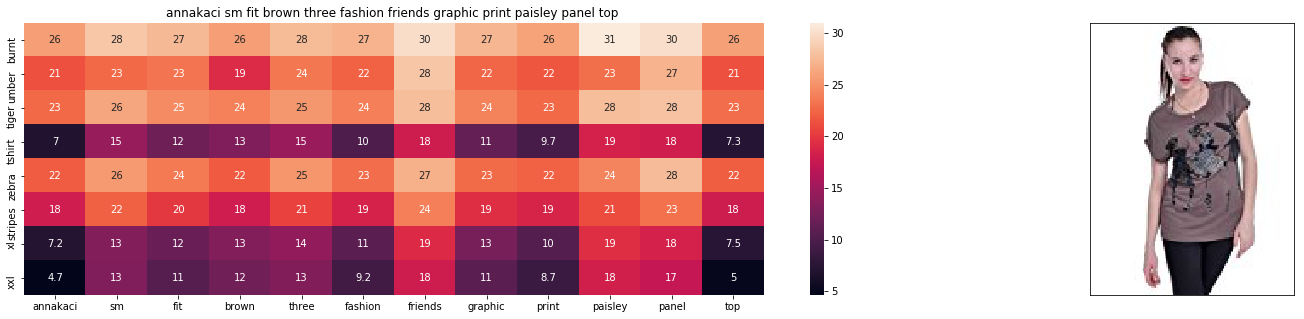

ASIN : B00BTJKAQ0
Brand : Anna-Kaci
euclidean distance from input : 4.620629420647254


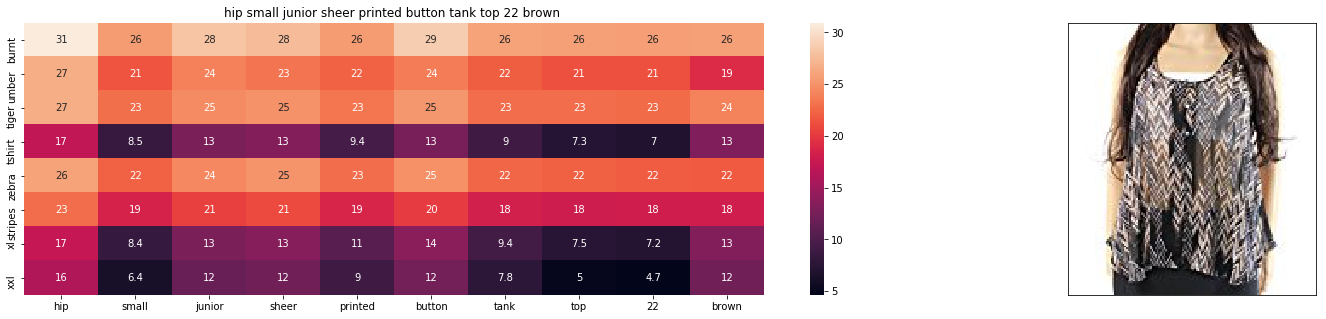

ASIN : B071LDTQ1F
Brand : Hip
euclidean distance from input : 4.626076031288539


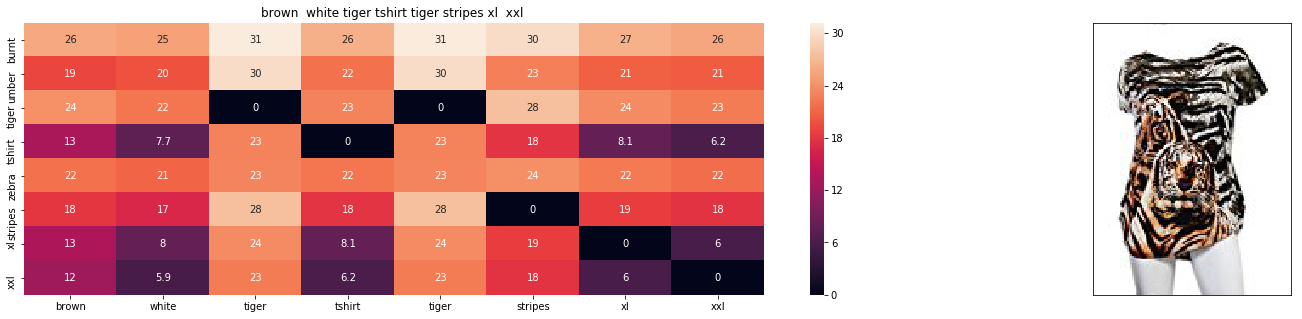

ASIN : B00JXQCWTO
Brand : Si Row
euclidean distance from input : 4.639908460470346


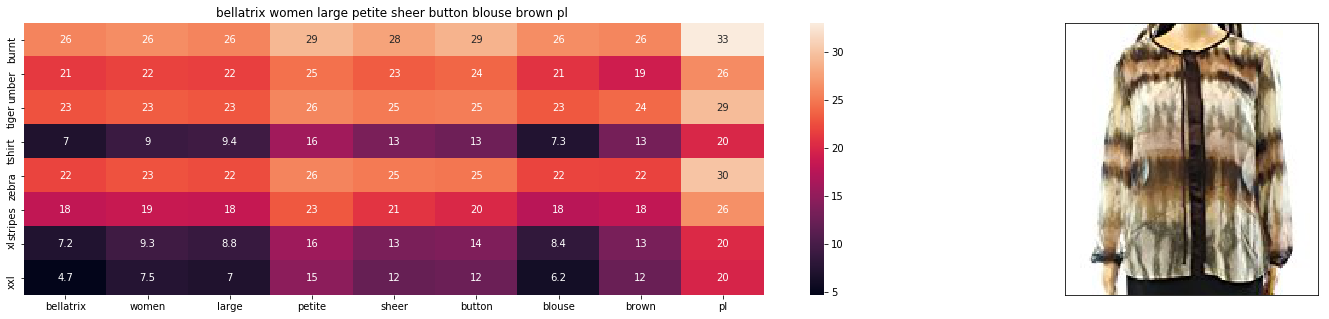

ASIN : B074QVMXSQ
Brand : bellatrix
euclidean distance from input : 4.640882632005937


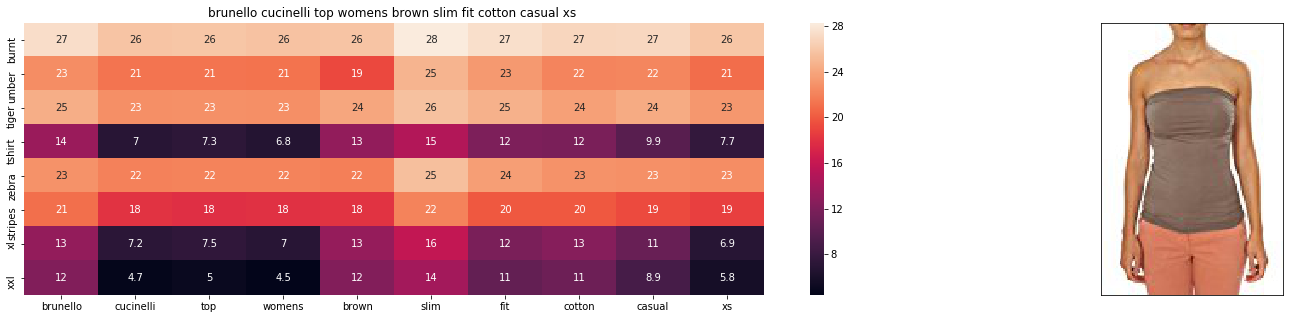

ASIN : B073ZCN5LG
Brand : Brunello Cucinelli
euclidean distance from input : 4.647615139301006


In [109]:
idf_w2v_brand_image(12566, 1, 1, 10, 1, 10)

In [106]:
bottleneck_features_train[12566].reshape(1,-1).shape

(1, 25088)